# Data access, query, collection and integration

## ARTchives exploration and data collection

First of all I studied the <b>artchives.nq and artchives.csv files</b>, that is, I did <b>some queries to explore the ARTchives dataset and looked at what possible relationships</b> there could be between the entities. So I got an idea of which historians and collections might be interested in the Renaissance also by reading the descriptions in natural language on the ARTchives website.
I then recovered <b>from wikidata the URIs of "Renaissance" and its genres or subcategories</b> (High Renaissance, Late Renaissance, Renaissance architecture), so as to <b>collect Renaissance artists with SPARQL queries</b> and save them in a set (there might be duplicates since one artist can belong both to the Renaissance art movement and the Renaissance architecture movement).

DISCLAIMER: from the start we intend <b>"Renaissance" as an art and "cultural movement</b> that spanned the period roughly from the 14th to the 17th century" (from wikidata: https://www.wikidata.org/wiki/Q4692). For this reason, Renaissance artists are collected through the predicate "movement" (P135): "iterary, artistic, scientific or philosophical movement or scene associated with this person or work" (from wikidata: https://www.wikidata.org/wiki/Property:P135).

In the following query the aim is to identify those artists that were exponents of the Renaissance or one of its forms. So the predicate of interest is wdt:P135 = movement. While the values of the variable "period" can be:
wd:Q4692 = renaissance;
wd:Q1472236 = Early Renaissance;
wd:Q1474884 = High Renaissance;
wd:Q979160 = Proto-Renaissance;
wd:Q236122 = renaissance architecture;
wd:Q1404472 = Italian Renaissance;
wd:Q15885248 = Renaissance painting;
wd:Q1133779 = Renaissance art;
wd:Q610687 = Venetian school;
wd:Q2455000 = German Renaissance.
The wdt:P1559 stands for "name in native language".

In [54]:
import ssl
import rdflib
import json
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper, JSON

rSet = set()

ssl._create_default_https_context = ssl._create_unverified_context
# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# id dei periodi storico-culturali: wd:Q11514315 wd:Q968159 wd:Q2198855 wd:Q578
# id dell'arte: wd:Q1792379 wd:Q64222339 wd:Q32880 wd:Q1231896 wd:Q1792644
# prepare the query
my_SPARQL_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/> 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT ?renaissanceArtist ?name
    WHERE {
      VALUES ?period {wd:4692 wd:Q1472236 wd:Q1474884 wd:Q979160 wd:Q236122 wd:Q1404472 wd:Q15885248
      wd:Q1133779 wd:Q610687 wd:Q2455000} .
      ?renaissanceArtist wdt:P135 ?period ;
                         wdt:P1559 ?name .
    }
    """

# set the endpoint
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

for item in results['results']['bindings']:
    rSet.add(item['renaissanceArtist']['value'])
    
genres = {'http://www.wikidata.org/entity/Q4692', 'http://www.wikidata.org/entity/Q1472236', 
          'http://www.wikidata.org/entity/Q1474884', 'http://www.wikidata.org/entity/Q979160',
          'http://www.wikidata.org/entity/Q236122', 'http://www.wikidata.org/entity/Q1404472', 
          'http://www.wikidata.org/entity/Q15885248', 'http://www.wikidata.org/entity/Q1133779',
          'http://www.wikidata.org/entity/Q610687', 'http://www.wikidata.org/entity/Q2455000' }

rSet.update(genres)
    
print(rSet)
    

{'http://www.wikidata.org/entity/Q285423', 'http://www.wikidata.org/entity/Q5811', 'http://www.wikidata.org/entity/Q154338', 'http://www.wikidata.org/entity/Q76568', 'http://www.wikidata.org/entity/Q9554', 'http://www.wikidata.org/entity/Q48319', 'http://www.wikidata.org/entity/Q1133779', 'http://www.wikidata.org/entity/Q296265', 'http://www.wikidata.org/entity/Q1472236', 'http://www.wikidata.org/entity/Q58768', 'http://www.wikidata.org/entity/Q5571', 'http://www.wikidata.org/entity/Q236122', 'http://www.wikidata.org/entity/Q8459', 'http://www.wikidata.org/entity/Q3116299', 'http://www.wikidata.org/entity/Q48900', 'http://www.wikidata.org/entity/Q5822', 'http://www.wikidata.org/entity/Q248615', 'http://www.wikidata.org/entity/Q507825', 'http://www.wikidata.org/entity/Q5664', 'http://www.wikidata.org/entity/Q2273503', 'http://www.wikidata.org/entity/Q153746', 'http://www.wikidata.org/entity/Q504963', 'http://www.wikidata.org/entity/Q191423', 'http://www.wikidata.org/entity/Q954504', 'ht

With this set we can <b>filter from artchives.nq those art historians or collections that have as subject interest one of the retrieved artists or Renaissance periods/genres</b>:

In [55]:
wd = Namespace("http://www.wikidata.org/entity/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph and parse the data
g = rdflib.ConjunctiveGraph()
g.parse("jupyter-resources/dataset-originali/artchives.nq", format='nquads')

selected = rdflib.ConjunctiveGraph()
subjectsLabel = set()
subjectsURI = set()

for e in rSet:
    element = URIRef(e)
    for s, p, o, c in g.quads():
        if element == o:
            selected.add((s, p, o, c))
            subjectsURI.add(s)
            for sub, pred, obj in g.triples((s, RDFS.label, None)):
                if obj:
                    subjectsLabel.add(obj.strip())
                
            
selected.serialize(destination='jupyter-resources/dataset-originali/artchives-totals-nq/selected.nq', format='nquads')
for i in subjectsLabel:
    print(i)

Everett Fahy
Ulrich Middledorf papers
Aby Warburg
Nachlass Wolfgang Lotz
Fototeca Zeri
Kornél Fabriczy
John Pope-Hennessy
Julian Kliemann
Leo Steinberg research papers
John Pope-Hennessy papers
Nachlass Werner Cohn
Ernst Steinmann
Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei
Ulrich Middeldorf
Ellis K. Waterhouse notebooks and research files
Nachlass Cornelius von Fabriczy
Kurt Badt
Gustav Ludwig-Vermächtnis
Nachlass Richard Krautheimer
Archivio Luisa Vertova
Nachlass Ernst Steinmann
Fototeca Fahy
Fototeca Stefano Tumidei
Fondo Aby Warburg
Fototeca Julian Kliemann
https://w3id.org/artchives/collectionnachlass-fritz-heinemann-notizen-zur-venezianischen-malerei
https://w3id.org/artchives/collectionfototeca-stefano-tumidei
https://w3id.org/artchives/collectionnachlass-ernst-steinmann
https://w3id.org/artchives/collectionleo-steinberg-research-papers
http://www.wikidata.org/entity/Q995470
http://www.wikidata.org/entity/Q60185
https://w3id.org/artchives/collectionjohn-popehen

Now I would like to distinguish historians from collections, to find out if it is the collection that has the Renaissance as its object of interest or if it is a historian directly. 
In addition to the total graph of subjects interested in the Renaissance, I create two separate graphs to distinguish historians interested in the Renaissance as individuals and collections interested in the Renaissance.

In [59]:
selectedG = rdflib.ConjunctiveGraph()
selectedG.parse("jupyter-resources/dataset-originali/artchives-totals-nq/selected.nq", format='nquads')

historians = set()
collections = set()
others = set() # just to check if there are expections or errors

collectionsG = rdflib.ConjunctiveGraph()
historiansG = rdflib.ConjunctiveGraph()

for item in subjectsURI:
    for s, p, o, c in selectedG.quads((item, RDF.type, None, None)):
        for sub, pred, sLabel, context in selectedG.quads((s, RDFS.label, None, None)):
            if URIRef('http://www.wikidata.org/entity/Q5') == o:
                historians.add(sLabel.strip())
                historiansG.add((s, p, o, c))
            elif URIRef('http://www.wikidata.org/entity/Q9388534') == o:
                collections.add(sLabel.strip())
                collectionsG.add((s, p, o, c))
            else:
                others.add(sLabel.strip())
                
                
collectionsG.serialize(destination='jupyter-resources/dataset-originali/artchives-totals-nq/collectionsG.nq', format='nquads')
historiansG.serialize(destination='jupyter-resources/dataset-originali/artchives-totals-nq/historiansG.nq', format='nquads')
                
print('number of historians interested in Renaissance: '+str(len(historians)))
for h in historians:
    print(h)
    
print("")
    
print('number of collections linked to Renaissance: '+str(len(collections)))
for c in collections:
    print(c)

print("")
    
print(others)

number of historians interested in Renaissance: 8
Everett Fahy
Ernst Steinmann
Ulrich Middeldorf
Aby Warburg
Kornél Fabriczy
Kurt Badt
John Pope-Hennessy
Julian Kliemann

number of collections linked to Renaissance: 17
Leo Steinberg research papers
Ulrich Middledorf papers
John Pope-Hennessy papers
Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei
Nachlass Richard Krautheimer
Ellis K. Waterhouse notebooks and research files
Nachlass Wolfgang Lotz
Nachlass Cornelius von Fabriczy
Fototeca Zeri
Nachlass Ernst Steinmann
Archivio Luisa Vertova
Fototeca Stefano Tumidei
Fototeca Fahy
Nachlass Werner Cohn
Fondo Aby Warburg
Fototeca Julian Kliemann
Gustav Ludwig-Vermächtnis

set()


The collections of the 8 historians interested in the Renaissance (historians set) are all included among the collections in turn related to the Renaissance (collections set), apart from that of Kurt Badt. Another particular case is that of Ulrich Middeldorf, of whom only one of the two collections in his name is directly linked to the Renaissance. So broadly speaking, we can say that our research will focus on <b>18 historians</b> (those of the 17 collection plus Kurt Badt). So I create a nq file for each historian:

In [60]:
def uniqueNQ(item, oldG):
    uniqueGNQ = rdflib.ConjunctiveGraph()
    for s, p, o, c in oldG.quads():
        if s == item:
            uniqueGNQ.add((item, p, o, c))

    return uniqueGNQ

vertova = uniqueNQ(URIRef('https://w3id.org/artchives/collectionarchivio-luisa-vertova'), g)
vertova.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//vertova.nq', format='nquads')

waterhouse = uniqueNQ(URIRef('https://w3id.org/artchives/collectionellis-k-waterhouse-notebooks-and-research-files'), g)
waterhouse.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//waterhouse.nq', format='nquads')

fahy = uniqueNQ(URIRef('https://w3id.org/artchives/collectionfototeca-fahy'), g)
fahy.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//fahy.nq', format='nquads')

kliemann = uniqueNQ(URIRef('https://w3id.org/artchives/collectionfototeca-julian-kliemann'), g)
kliemann.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//kliemann.nq', format='nquads')

zeri = uniqueNQ(URIRef('https://w3id.org/artchives/collectionfototeca-zeri'), g)
zeri.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//zeri.nq', format='nquads')

ludwig = uniqueNQ(URIRef('https://w3id.org/artchives/collectiongustav-ludwigvermachtnis'), g)
ludwig.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//ludwig.nq', format='nquads')

popehennessy = uniqueNQ(URIRef('https://w3id.org/artchives/collectionjohn-popehennessy-papers'), g)
popehennessy.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//pope-hennessy.nq', format='nquads')

steinberg = uniqueNQ(URIRef('https://w3id.org/artchives/collectionleo-steinberg-research-papers'), g)
steinberg.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//steinberg.nq', format='nquads')

fabriczy = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-cornelius-von-fabriczy'), g)
fabriczy.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//fabriczy.nq', format='nquads')

steinmann = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-ernst-steinmann'), g)
steinmann.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//steinmann.nq', format='nquads')

heinemann = uniqueNQ(URIRef(
         'https://w3id.org/artchives/collectionnachlass-fritz-heinemann-notizen-zur-venezianischen-malerei'), g)
heinemann.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//heinemann.nq', format='nquads')

krautheimer = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-richard-krautheimer'), g)
krautheimer.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//krautheimer.nq', format='nquads')

cohn = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-werner-cohn'), g)
cohn.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//cohn.nq', format='nquads')

warburg = uniqueNQ(URIRef('https://w3id.org/artchives/collectionfondo-aby-warburg'), g)
warburg.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//warburg.nq', format='nquads')

tumidei = uniqueNQ(URIRef('https://w3id.org/artchives/collectionfototeca-stefano-tumidei'), g)
tumidei.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//tumidei.nq', format='nquads')

lotz = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-wolfgang-lotz'), g)
lotz.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//lotz.nq', format='nquads')

badt = uniqueNQ(URIRef('http://www.wikidata.org/entity/Q1629748'), g)
badt.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//badt.nq', format='nquads')

# MIDDLEDORF PAPERS: collection linked with the Renaissance with a typo in its name
middledorfCollectionTYPO = uniqueNQ(URIRef('https://w3id.org/artchives/collectionulrich-middledorf-papers'), g)
middledorfCollectionTYPO.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//middledorfCollectionTYPO.nq', format='nquads')

# MIDDELDORF COLLECTIONNACHLASS: collection not directly linked with Renaissance, but one of the two by Middeldorf
middeldorfCollectionNOR = uniqueNQ(URIRef('https://w3id.org/artchives/collectionnachlass-ulrich-middeldorf'), g)
middeldorfCollectionNOR.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//middeldorfCollectionNOR.nq', format='nquads')

# # MIDDELDORF ART HISTORIAN !!!!!!!
middeldorfHISTORIAN = uniqueNQ(URIRef('http://www.wikidata.org/entity/Q1715096'), g)
middeldorfHISTORIAN.serialize(destination='jupyter-resources/dataset-originali/artchives-historians-nq//middeldorf.nq', format='nquads')



## Data integration
For the integration of data from sources external to ARTchives we have chosen <b>SNAC</b> (Social Networks and Archival Context: https://snaccooperative.org/) and <b>WorldCat Identities</b> (https://www.worldcat.org/identities/). First of all, we have chosen them for their authority in the field of Linked Open Data and Semantic Web. Secondly, because they have types of data that we need to answer the questions we asked ourselves, namely: data on publications or resources related to historians (questions 1, 2 and 3, therefore the <b>dates</b> of publication of writings of archives and <b>subjects</b> of interest), and data on their study subjects (question 3). Thirdly, because both allow us to download the machine readable format of the contents concerning the historians of our interest, allowing us to automatically manipulate the data.

So I downloaded from SNAC the <b>json files</b> of 11 out of 18 historians of our research (Fahy, Krautheimer, Lotz, Middeldorf, Pope-Hennessy, Steinberg, Steinmann, Vertova, Warburg, Waterhouse, Zeri); and 18 <b>XML files</b>, one for each historian, from the WorldCat identities API (https://platform.worldcat.org/api-explorer/apis/worldcatidentities/identity/Search).

### First question addressed: question 3: Are there aspects of the Renaissance that have been studied more by historians?

Starting from the subjects, in order to answer to question three, I noticed that only 5 out of the 11 files from SNAC have data regarding the subjects of interest of the historian; those are: Krautheimer, Middeldorf, Steinberg, Warburg and Waterhouse. So I collect the subjects from the json files and update the nq files of each historian retrieved from ARTchives:

In [9]:
import json
import rdflib
from rdflib.namespace import XSD
from rdflib import Literal
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib import Namespace
from rdflib.namespace import RDF, RDFS

# assign prefixes to namespaces
wd = Namespace("http://www.wikidata.org/entity/")
wdp = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")

def retrieve_subjects(json_file_path, historian, nqfile_to_supplement, historian_name):
    with open(json_file_path, errors='ignore', encoding='utf-8') as inputjson:
        data = json.load(inputjson)

    subjectsToAdd = []

    subjectsValueList = data['subjects']
    for dictionary in subjectsValueList:
        subjectsToAdd.append(dictionary['term']['term'])
   
    print("\n"+historian_name+" subjects: "+str(subjectsToAdd)) # print the subjects to have an idea of what has to be added
    
    g = rdflib.ConjunctiveGraph()
    g.parse(nqfile_to_supplement, format='nquads')  # parse the RDF file of the historian
    for sub in subjectsToAdd:  # add to the graph a triple for each subject of interest
        object_subject = Literal(sub, lang="en")  # specify the lang parameter
        g.add((historian, wdp.P921, object_subject)) 
    g.serialize(
        destination='jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/{}_enhanced.nq'.format(historian_name),
        format='nquads')


retrieve_subjects('jupyter-resources/dataset-originali/SNAC-json/middeldorf.json', URIRef("http://www.wikidata.org/entity/Q1715096"), 'jupyter-resources/dataset-originali/artchives-historians-nq/middeldorf.nq', 'middeldorf')
retrieve_subjects('jupyter-resources/dataset-originali/SNAC-json/waterhouse.json', URIRef("http://www.wikidata.org/entity/Q3051533"), 'jupyter-resources/dataset-originali/artchives-historians-nq/waterhouse.nq', 'waterhouse')
retrieve_subjects('jupyter-resources/dataset-originali/SNAC-json/krautheimer.json', URIRef("http://www.wikidata.org/entity/Q90407"), 'jupyter-resources/dataset-originali/artchives-historians-nq/krautheimer.nq', 'krautheimer')
retrieve_subjects('jupyter-resources/dataset-originali/SNAC-json/steinberg.json', URIRef("http://www.wikidata.org/entity/Q457739"), 'jupyter-resources/dataset-originali/artchives-historians-nq/steinberg.nq', 'steinberg')
retrieve_subjects('jupyter-resources/dataset-originali/SNAC-json/warburg.json', URIRef("http://www.wikidata.org/entity/Q60185"), 'jupyter-resources/dataset-originali/artchives-historians-nq/warburg.nq', 'warburg')


middeldorf subjects: ['Art metal-work', 'Bronzes, Renaissance', 'Clothing and dress', 'Decorative art', 'Art historians']

waterhouse subjects: ['Architecture, Domestic--Great Britain', 'Architecture--Italy', 'Mannerism (Art)', 'Architecture, Domestic', 'Country homes', 'Art, Baroque--Italy', 'Art historians', 'Collectors and collecting', 'Art--Private collections', 'Arts, Baroque']

krautheimer subjects: ['Architecture, Baroque', 'Architecture--Study and teaching']

steinberg subjects: ['Art critics--United States', 'Art historians--United States', 'Art, Modern--History', 'Art--History--Study and teaching (Graduate)--United States', 'Art critics', 'Art--History--Study and teaching (Graduate)', 'Art historians', 'Art, Modern--History']

warburg subjects: ['Art criticism--History--20th century', 'Art historians--Correspondence']


Now I want to retrieve the subjects of interest from the WorldCat Identities XML files and update the nq files of each historian retrieved from ARTchives:

In [13]:
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as etree
import rdflib
from rdflib.namespace import XSD
from rdflib import Literal
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib import Namespace
from rdflib.namespace import RDF, RDFS
from pprint import pprint

# assign prefixes to namespaces
wd = Namespace("http://www.wikidata.org/entity/")
wdp = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")

def retrieve_xml_subjects(xml_file_path, historian, nqfile_to_supplement, historian_name, boolean):
    with open(xml_file_path, 'r', encoding='utf-8') as xml_file:
        tree = etree.parse(xml_file)
    root = tree.getroot()

    subjectsList = []
    for elem in root[5][2]: # the xml element root[5][2] is a list containing the subjects of interest
        subjectsList.append(elem.text)

    print("\n"+historian_name+" subjects: "+str(subjectsList)) # print the subjects to have an idea of what has to be added
    
    g = rdflib.ConjunctiveGraph()
    g.parse(nqfile_to_supplement, format='nquads') # parse the RDF file of the historian
    for sub in subjectsList: # add to the graph a triple for each subject of interest
        object_subject = Literal(sub, lang="en") # specify the lang parameter 
        g.add((historian, wdp.P921, object_subject))
    if boolean:
        g.serialize(destination='jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/{}_enhanced.nq'.format(historian_name), format='nquads')
    else:
        g.serialize(destination='jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/{}_enhanced.nq'.format(historian_name), format='nquads')
    
    

retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/badt.xml', URIRef("http://www.wikidata.org/entity/Q1629748"), 'jupyter-resources/dataset-originali/artchives-historians-nq/badt.nq', 'badt', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/cohn.xml', URIRef("http://www.wikidata.org/entity/Q18935222"), 'jupyter-resources/dataset-originali/artchives-historians-nq/cohn.nq', 'cohn', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/fabriczy.xml', URIRef("http://www.wikidata.org/entity/Q995470"), 'jupyter-resources/dataset-originali/artchives-historians-nq/fabriczy.nq', 'fabriczy', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/fahy.xml', URIRef("http://www.wikidata.org/entity/Q19997512"), 'jupyter-resources/dataset-originali/artchives-historians-nq/fahy.nq', 'fahy', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/kliemann.xml', URIRef("http://www.wikidata.org/entity/Q85761254"), 'jupyter-resources/dataset-originali/artchives-historians-nq/kliemann.nq', 'kliemann', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/heinemann.xml', URIRef("http://www.wikidata.org/entity/Q1271052"), 'jupyter-resources/dataset-originali/artchives-historians-nq/heinemann.nq', 'heinemann', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/krautheimer.xml', URIRef("http://www.wikidata.org/entity/Q90407"), 'jupyter-resources/dataset-originali/artchives-historians-nq/krautheimer.nq', 'krautheimer', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/lotz.xml', URIRef("http://www.wikidata.org/entity/Q1296486"), 'jupyter-resources/dataset-originali/artchives-historians-nq/lotz.nq', 'lotz', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/ludwig.xml', URIRef("http://www.wikidata.org/entity/Q41616785"), 'jupyter-resources/dataset-originali/artchives-historians-nq/ludwig.nq', 'ludwig', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/middeldorf.xml', URIRef("http://www.wikidata.org/entity/Q1715096"), 'jupyter-resources/dataset-originali/artchives-historians-nq/middeldorf.nq', 'middeldorf', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/pope-hennessy.xml', URIRef("http://www.wikidata.org/entity/Q537874"), 'jupyter-resources/dataset-originali/artchives-historians-nq/pope-hennessy.nq', 'pope-hennessy', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/steinberg.xml', URIRef("http://www.wikidata.org/entity/Q457739"), 'jupyter-resources/dataset-originali/artchives-historians-nq/steinberg.nq', 'steinberg', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/steinmann.xml', URIRef("http://www.wikidata.org/entity/Q3057287"), 'jupyter-resources/dataset-originali/artchives-historians-nq/steinmann.nq', 'steinmann', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/tumidei.xml', URIRef("http://www.wikidata.org/entity/Q55453618"), 'jupyter-resources/dataset-originali/artchives-historians-nq/tumidei.nq', 'tumidei', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/vertova.xml', URIRef("http://www.wikidata.org/entity/Q61913691"), 'jupyter-resources/dataset-originali/artchives-historians-nq/vertova.nq', 'vertova', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/warburg.xml', URIRef("http://www.wikidata.org/entity/Q60185"), 'jupyter-resources/dataset-originali/artchives-historians-nq/warburg.nq', 'warburg', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/waterhouse.xml', URIRef("http://www.wikidata.org/entity/Q3051533"), 'jupyter-resources/dataset-originali/artchives-historians-nq/waterhouse.nq', 'waterhouse', True)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/zeri.xml', URIRef("http://www.wikidata.org/entity/Q1089074"), 'jupyter-resources/dataset-originali/artchives-historians-nq/zeri.nq', 'zeri', True)


badt subjects: ['Cezanne, Paul,', 'France', 'Painters', 'Clouds in art', 'Art', 'Delacroix, Eugene,', 'Composition (Art)', 'Badt, Kurt,', 'Constable, John,', 'Gogh, Vincent van,', 'Landscape painting', 'Painting--Technique', 'Artists--Psychology', 'Poussin, Nicolas,', 'Art--Historiography', 'Art--Philosophy', 'Veronese,', 'Perspective', 'Riegl, Alois,', 'Solario, Andrea,', 'Travel', 'Vermeer, Johannes,', 'Italy--Florence', 'England--London', 'Italy--Rome', 'Painting--Themes, motives', 'Painters--Psychology', 'Europe--Lake Constance', 'Europe', 'Cities and towns', 'Germany', 'Art historians', 'Space and time in art', 'Constable, John', "Artists' preparatory studies", "Artist's studio (Vermeer, Johannes)", 'Music', 'Sedlmayr, Hans,', 'Art appreciation', 'Picture interpretation', 'Drawing', 'Lithography', 'Color', 'Post-impressionism (Art)', 'Snyders, Frans,', 'Painting, Flemish']

cohn subjects: ['Pottery, Italian', 'Majolica', 'Wood-engraving', 'Germany', 'Italy--Ravenna', 'Mosaics', '


steinmann subjects: ['Michelangelo Buonarroti,', 'Botticelli, Sandro,', 'Italy--Rome', 'Art', 'Italy', 'Ghirlandaio, Domenico,', 'Painters', 'Pintoricchio,', 'Renaissance', 'Art, Renaissance', 'Travel', 'Architecture', 'Sixtus--IV,--Pope,', 'Julius--II,--Pope,', 'Cappella Sistina (Vatican Palace, Vatican City)', 'Sculpture', 'British Museum', 'Italy--Florence', 'Medici, House of', 'Steinmann, Ernst,', 'Art libraries', 'Bibliotheca Hertziana, Max-Planck-Institut', 'Paul--III,--Pope,', 'Basilica di San Pietro in Vaticano', 'Sepulchral monuments', 'Tombs', 'Vatican City', 'Mural painting and decoration, Italian', 'Buildings', 'Painting, Renaissance', 'Bibliography', 'Mural painting and decoration', 'Rome (Empire)', 'Vatican Palace (Vatican City)', 'Cappella Sistina (Santa Maria Maggiore (Church : Rome, Italy))', 'Palazzo Zuccari (Rome, Italy)', 'Libraries']

tumidei subjects: ['Art, Italian', 'Italy--Bologna', 'Italy', 'Italy--Romagna', 'Plein air painting', 'Painting, Renaissance', 'Lan

For warburg, steinberg, krautheimer, waterhouse e middeldorf I add the subjects from WorldCat to the nq files already enhanced with subjects from SNAC:

In [14]:
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/warburg.xml', URIRef("http://www.wikidata.org/entity/Q60185"), 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/warburg_enhanced.nq', 'warburg', False)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/steinberg.xml', URIRef("http://www.wikidata.org/entity/Q457739"), 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/steinberg_enhanced.nq', 'steinberg', False)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/krautheimer.xml', URIRef("http://www.wikidata.org/entity/Q90407"), 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/krautheimer_enhanced.nq', 'krautheimer', False)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/middeldorf.xml', URIRef("http://www.wikidata.org/entity/Q1715096"), 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/middeldorf_enhanced.nq', 'middeldorf', False)
retrieve_xml_subjects('jupyter-resources/dataset-originali/worldcatIdentities-xml/waterhouse.xml', URIRef("http://www.wikidata.org/entity/Q3051533"), 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC-enhanced/waterhouse_enhanced.nq', 'waterhouse', False)    


warburg subjects: ['Warburg, Aby,', 'Art historians', 'Germany', 'Art--Historiography', 'Art', 'Art, Renaissance', 'Panofsky, Erwin,', 'Cassirer, Ernst,', 'England', 'Aesthetics, Modern', 'Motion in art', 'Aesthetics, German', 'Pueblo Indians--Religion', 'Germany--Hamburg', 'Art--Philosophy', 'Serpent worship', 'Italy--Florence', 'Renaissance', 'Civilization', 'Intellectual life', 'Pueblo Indians--Social life and customs', 'New Southwest', 'Frontier and pioneer life', 'Benjamin, Walter,', 'Philosophy', 'Antisemitism', 'Jews--Identity', 'Usener, Hermann,', 'Art and anthropology', 'Art, German', 'Warburg Institute', 'Nuclear weapons', 'Oppenheimer, J. Robert,', 'Travel', 'Historiography', 'Art, Italian', 'Saxl, Fritz,', 'Knowledge, Theory of (Religion)', 'Science--Philosophy', 'Influence (Literary, artistic, etc.)', 'Dieterich, Albrecht,', 'Otto, Walter Friedrich,', 'Radermacher, Ludwig,', 'Philosophy, Comparative', 'Art critics', 'Artists', 'History, Modern', 'Italy', 'Arizona', 'Cultu

Now I want to create a csv file for each historian with all of their subjects of interest. 
To obtain this file I execute a <b>SPARQL query on each of the nq files of the historians</b> of our interest, retrieving the triples whose predicate is one of the following: wdp:P921, art:hasScopeAndContentSubject, art:hasSubjectArtist, art:hasSubjectArtwork, art:hasSubjectGenre, art:hasSubjectObject, art:hasSubjectPeople, art:hasSubjectPeriod.
The result is a <b>csv file for each historian</b>, in which the URIs of the <b>subjects</b> of the triples and their label are reported (so as to distinguish the interests of the collections from those of the historians), the <b>type of interest</b> (i.e. the predicate of the triple) and the URI of the <b>interest</b> with respective label if present, or the Literal that is the object of the triple.

In [16]:
import csv
import rdflib
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib import Namespace
from rdflib.namespace import RDF, RDFS
from pprint import pprint

# Execute SPARQL queries with RDFLib on a local RDF file

wd = Namespace("http://www.wikidata.org/entity/")
wdp = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

def to_csv(nq_file_path, csv_file_path):
    g = rdflib.ConjunctiveGraph()
    g.parse(nq_file_path, format='nquads')
    
    query_results = g.query(
        """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX wd: <http://www.wikidata.org/entity/> 
        PREFIX wdp: <http://www.wikidata.org/prop/direct/> 
        PREFIX art: <https://w3id.org/artchives/>
        SELECT DISTINCT ?subject ?subjectLabel ?typeOfInterest ?interest ?interestLabel
        WHERE { 
            ?subject ?typeOfInterest ?interest ;
                rdfs:label ?subjectLabel .            
            FILTER(?typeOfInterest IN (wdp:P921, art:hasScopeAndContentSubject, art:hasSubjectArtist, art:hasSubjectArtwork, art:hasSubjectGenre, art:hasSubjectObject, art:hasSubjectPeople, art:hasSubjectPeriod))
            FILTER(?subject NOT IN (art:biblioOnCollection, art:biblioOnArtHistorian))
            OPTIONAL {?interest rdfs:label ?interestLabel .}
        }
        ORDER BY ?subjectName""")

    with open(csv_file_path, mode='w', encoding='utf-8', newline='') as my_file:
        my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL, skipinitialspace=True)
        # write the column names
        my_writer.writerow(['subject', 'subjectLabel', 'typeOfInterest', 'interest', 'interestLabel'])
        # access the rows of the query results
        for subject, subjectLabel, typeOfInterest, interest, interestLabel in query_results:
            # write in the csv
            if interestLabel:
                my_writer.writerow([subject, subjectLabel.strip(), typeOfInterest, interest.strip(), interestLabel.strip()])
            else:
                my_writer.writerow([subject, subjectLabel.strip(), typeOfInterest, interest.strip()])


# the 5 historians whose ARTchives subjects have been integrated both with those of SNAC and WC:
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/krautheimer_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/krautheimerSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/middeldorf_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/middeldorfSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/steinberg_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/steinbergSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/warburg_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/warburgSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/SNAC+WORLDCAT/waterhouse_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/waterhouseSUBJECTS.csv')

# the other historians, whose ARTchives subjects have been integrated only with those of WC:
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/badt_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/badtSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/cohn_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/cohnSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/fabriczy_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/fabriczySUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/fahy_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/fahySUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/heinemann_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/heinemannSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/kliemann_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/kliemannSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/lotz_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/lotzSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/ludwig_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/ludwigSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/pope-hennessy_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/pope-hennessySUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/steinmann_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/steinmannSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/tumidei_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/tumideiSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/vertova_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/vertovaSUBJECTS.csv')
to_csv('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/WORLDCAT-enhanced/zeri_enhanced.nq', 'jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/zeriSUBJECTS.csv')

These csv are then merged in one csv file (automatic_all.csv):

In [2]:
import csv

def all_csv(l):
    all = []
    for e in l:
        with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/{}SUBJECTS.csv'.format(e),
                  'r', encoding='utf-8') as historiancsv:
            ancillary = []
            csvreader = csv.reader(historiancsv)
            for row in csvreader:
                ancillary.append(row)

        i = 1
        while i < len(ancillary):
            all.append(ancillary[i])
            i += 1

    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/automatic_all.csv', mode='w', encoding='utf-8', newline='') as my_file:
        my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL, skipinitialspace=True)
        # write the column names
        my_writer.writerow(['subject', 'subjectLabel', 'typeOfInterest', 'interest', 'interestLabel'])
        for item in all:
            my_writer.writerow(item)


historians = ['badt', 'cohn', 'vertova', 'warburg', 'fahy', 'kliemann', 'tumidei', 'zeri', 'pope-hennessy', 'steinberg', 'fabriczy', 'steinmann', 'heinemann', 'krautheimer', 'lotz', 'middeldorf', 'waterhouse', 'ludwig']

all_csv(historians)

Then we removed duplicates (clean_allmod.csv) and created a csv file in which we have replaced the collections as subjects with the corresponding art historians (clean_allmodonlyhistorians.csv).

#### Data reconciliation

For now subjects of interest are integrated as literals, while it's better to retrieve the correspondant identifier (Wikidata URI) to have a unique and unambiguous identifier for the data analysis and the reconciliation with original data. After some tries with Wikidata SPARQL endpoint, the best option seems the <b>Wikidata API</b>, using the action: 'wbsearchentities'. <b>Retrieving the URI</b> of a concept allow us to automatically obtain more information about it, which can be useful <b>to categorize it</b>, i.e. to know in a (semi-)automatic way if it is an artifact, a person, an art movement or technique and so on. The <b>final check to the retrieved matching is done manually</b>, to ensure that the found URI correspond to the concept of the literal. Correct data is manually added to the clean_allmod.csv file. Surprisingly, the final csv file (then cleaned from duplicates again, called subjects_interests.csv) is bigger than the original one: that is because some literals contained multiple concepts, and then the rows with those kind of literals have been replaced with several rows with different URIs.

First, I look for entities corresponding to the literal as it currently is.

In [ ]:
import ssl
import csv
import rdflib
import re
import json
import requests
from rdflib.namespace import XSD
from difflib import SequenceMatcher
from rdflib import Literal
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper, JSON


def search_in_wikidata():
    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/clean_allmod.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    totwithoutURIbeforequery = 0
    totwithouturi = 0
    queryWithResults = 0

    for entry in data:
        if not entry['interestLabel']:
            totwithoutURIbeforequery += 1
            # clean entry["interest"]
            interest = str(entry['interest']) # interest is a string like "gogh, vincent van,"
            punc_list = [".", ";", ":", "!", "?", "/", ",", "(", ")", "'\ufffd'"]
            literal = ""
            for i in interest:
                literal += i if i not in punc_list else " "
                literal = re.sub(' +', ' ', literal)

                #do the query
                params = {
                    'action': 'wbsearchentities',
                    'format': 'json',
                    'language': 'en',
                    'search': literal
                }
                # query wd API
                API_WD = "https://www.wikidata.org/w/api.php"
                results = requests.get(API_WD, params=params).json()

                if len(results["search"]) > 0:
                    totwithouturi += 1
                    queryWithResults += 1
                    # print("")
                    # print("for " + literal + " there's something: ")
                    # for element in results['search']:
                        # print('"' + str(element['concepturi']) + '","' + element['label'] + '"')

                else:
                    totwithouturi += 1
                    # print("")
                    # print("NO MATCHING EVEN WITH THE QUERY")

    # print(len(data))
    # print(totwithoutURIbeforequery)
    # print(totwithouturi)
    # print(queryWithResults)


search_in_wikidata()

Then the same function is slightly modified to run the same query on the API but passing as a parameter to search the original literal with its component words reversed (only in cases where it consists of two or three words):

In [ ]:
def search_in_wikidata_inverted():
    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/clean_allmod.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    totwithoutURIbeforequery = 0
    totwithouturi = 0
    queryWithResults = 0

    for entry in data:
        if not entry['interestLabel']:
            totwithoutURIbeforequery += 1
            # clean entry["interest"]
            interest = str(entry['interest']) # interest is a string like "gogh, vincent van,"
            punc_list = [".", ";", ":", "!", "?", "/", ",", "(", ")", "'\ufffd'"]
            literal = ""
            for i in interest:
                literal += i if i not in punc_list else " "
                literal = re.sub(' +', ' ', literal)

                newLiteral = ''
                for letter in literal:
                    newLiteral += letter # if letter != "-" else " "
                wordsList = newLiteral.split()
                if len(wordsList) == 2:
                    cambio = wordsList[0]
                    wordsList[0] = wordsList[len(wordsList) - 1]
                    wordsList[len(wordsList) - 1] = cambio
                elif len(wordsList) == 3:
                    cambio = wordsList[0]
                    cambioo = wordsList[1]
                    cambiooo = wordsList[2]
                    wordsList[0] = cambioo
                    wordsList[1] = cambiooo
                    wordsList[2] = cambio
                    invertedLiteral = " ".join(wordsList)
                # if '--' in literal:
                    # invertedLiteral = literal.split('--')[1]
                else:
                    invertedLiteral = literal
                
                #do the query
                params = {
                    'action': 'wbsearchentities',
                    'format': 'json',
                    'language': 'en',
                    'search': invertedLiteral
                }
                # query wd API
                API_WD = "https://www.wikidata.org/w/api.php"
                results = requests.get(API_WD, params=params).json()

                if len(results["search"]) > 0:
                    totwithouturi += 1
                    queryWithResults += 1
                    # print("")
                    # print("for " + literal + " there's something: ")
                    # for element in results['search']:
                        # print('"' + str(element['concepturi']) + '","' + element['label'] + '"')

                else:
                    totwithouturi += 1
                    # print("")
                    # print("NO MATCHING EVEN WITH THE QUERY")

    # print(len(data))
    # print(totwithoutURIbeforequery)
    # print(totwithouturi)
    # print(queryWithResults)


search_in_wikidata_inverted()

Finally, to answer question 3, I take into consideration the subject of interest for each line of the csv file, now updated with as many Wikidata URIs as possible for each interest retrieved from external sources initially as a string.
If the value of the 'interest' key is a literal, i.e., if the value of the 'interestLabel' key is empty, then I search if there is the word 'Renaissance' within the string (I am only looking for this word because analyzing the dataset I realized that most URI-free interests are artistic periods or genres, and not people or artifacts).
If, on the other hand, the value of the 'interestLabel' field is there, then I take the URI of that interest and I look for some of their characteristics on wikidata, or better: I look for the claims to which it is subject by selecting the relevant predicates for the search.
I run several times the function to avoid getting the "Too Many Requests" error from the Wikidata SPARQL endpoint.

In [ ]:
def retrieve_renaissance_implicit_subjects2(n, m, num):
    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/allmodonlyhistorians.csv', 'r',
              encoding='utf-8') as totalCSV:
        bigdata = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            bigdata.append(row)

    renaissanceArtistsURI = [
        'http://www.wikidata.org/entity/Q5827', 'http://www.wikidata.org/entity/Q7780', 'http://www.wikidata.org/entity/Q8457', 'http://www.wikidata.org/entity/Q8459', 'http://www.wikidata.org/entity/Q8506', 'http://www.wikidata.org/entity/Q17169', 'http://www.wikidata.org/entity/Q113089', 'http://www.wikidata.org/entity/Q128027', 'http://www.wikidata.org/entity/Q182128', 'http://www.wikidata.org/entity/Q195655', 'http://www.wikidata.org/entity/Q309736', 'http://www.wikidata.org/entity/Q313310', 'http://www.wikidata.org/entity/Q314797', 'http://www.wikidata.org/entity/Q325930', 'http://www.wikidata.org/entity/Q326158', 'http://www.wikidata.org/entity/Q345605', 'http://www.wikidata.org/entity/Q605447', 'http://www.wikidata.org/entity/Q739267', 'http://www.wikidata.org/entity/Q861385', 'http://www.wikidata.org/entity/Q968593', 'http://www.wikidata.org/entity/Q1291233', 'http://www.wikidata.org/entity/Q1350301', 'http://www.wikidata.org/entity/Q7814', 'http://www.wikidata.org/entity/Q315249', 'http://www.wikidata.org/entity/Q364413', 'http://www.wikidata.org/entity/Q504963', 'http://www.wikidata.org/entity/Q5594','http://www.wikidata.org/entity/Q5669', 'http://www.wikidata.org/entity/Q5822', 'http://www.wikidata.org/entity/Q37562', 'http://www.wikidata.org/entity/Q174330', 'http://www.wikidata.org/entity/Q208125', 'http://www.wikidata.org/entity/Q2273503', 'http://www.wikidata.org/entity/Q2610648', 'http://www.wikidata.org/entity/Q762', 'http://www.wikidata.org/entity/Q1399', 'http://www.wikidata.org/entity/Q5571', 'http://www.wikidata.org/entity/Q5597', 'http://www.wikidata.org/entity/Q7793', 'http://www.wikidata.org/entity/Q9440', 'http://www.wikidata.org/entity/Q47551', 'http://www.wikidata.org/entity/Q48900', 'http://www.wikidata.org/entity/Q176694', 'http://www.wikidata.org/entity/Q285423', 'http://www.wikidata.org/entity/Q285423', 'http://www.wikidata.org/entity/Q310973', 'http://www.wikidata.org/entity/Q954504', 'http://www.wikidata.org/entity/Q295929','http://www.wikidata.org/entity/Q5664', 'http://www.wikidata.org/entity/Q5811', 'http://www.wikidata.org/entity/Q183458', 'http://www.wikidata.org/entity/Q191423', 'http://www.wikidata.org/entity/Q248615', 'http://www.wikidata.org/entity/Q296265'
    ]
    renaissanceArtists = [
        'Raphael', 'Perugino', 'Bartolommeo', 'Bellini', 'Garnier', 'Vasari', 'della Mirandola', 'della Robbia', 'della Quercia',
        'Rossellino', 'Costeley', 'Zuccari', 'Tempesta', 'Tibaldi', 'Giotto', 'di Bondone', 'di Cambio', 'Pisano',
        'Memmi', 'da Messina', 'Botticelli', 'della Francesca', 'Brunelleschi', 'Ghiberti', 'da Vinci', 'Machiavelli',
        'del Sarto', 'Sanzio', 'Bramante', 'Veronese', 'Tiziano', 'Vecellio', 'Titian', 'Ariosto', 'Lotto', 'Bonvicino', 'Angelico', 'del Verrocchio', 'Ghirlandaio', 'Gozzoli', 'Lippi', 'Filippino', 'Pietro Perugino', 'Fra-Bartolommeo', 'Correggio', 'Giorgione', 'Il Sodoma', 'Giovanni Bellini', 'Robert Garnier', 'Giorgio Vasari', 'Giovanni Pico della Mirandola', 'Andrea della Robbia', 'Michelozzo', 'Jacopo Bellini', 'Jacopo della Quercia', 'Bernardo Rossellino', 'Guillaume Costeley', 'Federico Zuccari', 'Antonio Tempesta', 'Bartolomeo Bon', 'Pellegrino Tibaldi', 'Claudin de Sermisy', 'Stanisław Samostrzelnik', 'Tullio Lombardo', 'Giotto di Bondone', 'Arnolfo di Cambio', 'Nicola Pisano', 'Lippo Memmi', 'Antonello da Messina', 'Sandro Botticelli', 'Piero della Francesca', 'Donatello', 'Filippo Brunelleschi', 'Lorenzo Ghiberti', 'Colantonio', "Jean Cousin l'Ancien", 'Leonardo da Vinci', 'Niccolò di Bernardo dei Machiavelli', 'Andrea del Sarto', 'Raffaello Sanzio', 'Donato Bramante', 'Paolo Veronese', 'Tiziano Vecellio', 'Ludovico Ariosto', 'Mor van Dashorst', 'Anthonie', 'Sebastiano Luciani', 'Sebastiano del Piombo', 'Lorenzo Lotto', 'Alessandro Bonvicino', 'Inigo Jones', 'Fra Angelico', 'Masaccio', 'Andrea del Verrocchio', 'Domenico Ghirlandaio', 'Benozzo Gozzoli', 'Filippino Lippi', 'Da Sangallo'
    ]
    movements = [
        'http://www.wikidata.org/entity/Q25111456', 'http://www.wikidata.org/entity/Q936588', 'http://www.wikidata.org/entity/Q15885248', 'http://www.wikidata.org/entity/Q236122', 'http://www.wikidata.org/entity/Q1472236', 'http://www.wikidata.org/entity/Q1474884', 'http://www.wikidata.org/entity/Q979160', 'http://www.wikidata.org/entity/Q1133779', 'http://www.wikidata.org/entity/Q1404472', 'http://www.wikidata.org/entity/Q4692'
    ]
    interestsToExclude = [
        'expressionism', 'mannerism', 'Impressionism', 'Romanticism', 'neoclassicism', 'University', 'Mannerism', 'Renaissance', 'medieval art', 'Baroque', 'Baroque art'
    ]

    listToAdd = []
    tocheck = set()

    data = bigdata[n:m]
    for entry in data:
        print("                   ")
        found = False
        if not entry['interestLabel']:
            for artist in renaissanceArtists:
                if artist.lower() in entry['interest'].lower() or entry['interest'].lower() in artist.lower():
                    dictToAdd = {'historian': entry['subjectLabel'],
                                 'interest': entry['interest'],
                                 'type': 'artist'}
                    listToAdd.append(dictToAdd)
                    print(' not entryinterestLabel found ' + entry['interest'] + ' in renaissanceArtists')

        elif entry['interestLabel']:
            for artistURI in renaissanceArtistsURI:
                if artistURI == entry['interest'] and not found:
                    dictToAdd = {'historian': entry['subjectLabel'],
                                 'interest': entry['interestLabel'],
                                 'type': 'artist'}
                    listToAdd.append(dictToAdd)
                    found = True
                    print('entry with interestURI: found ' + entry['interestLabel'] + ' in renaissanceArtistsURI')
                else:
                    for artist in renaissanceArtists:
                        if (artist.lower() in entry['interestLabel'].lower() or entry['interestLabel'].lower() in artist.lower()) and not found:
                            dictToAdd = {'historian': entry['subjectLabel'],
                                         'interest': entry['interestLabel'],
                                         'type': 'artist'}
                            listToAdd.append(dictToAdd)
                            found = True
                            print('entry with interestURI: found ' + entry['interestLabel'] + ' in renaissanceArtists')
            for item in interestsToExclude:
                if item in entry['interestLabel']:
                    print(str(entry['interestLabel']) + ' not relevant')
                    found = True
                    break

            if not found:
                URI = '<' + entry['interest'] + '>'
                ssl._create_default_https_context = ssl._create_unverified_context
                # get the endpoint API
                wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
                # prepare the query
                my_SPARQL_query = """
                                    PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
                                    SELECT ?p ?o 
                                    WHERE {
                                      VALUES ?p { wdt:P31 wdt:P39 wdt:P106 wdt:P135 wdt:P136 wdt:P172
                                      wdt:P569 wdt:P571 wdt:P135 wdt:P2348 wdt:P149 wdt:P170} .
                                      """ + URI + """ ?p ?o .
                                    }
                                    """
                # set the endpoint
                sparql_wd = SPARQLWrapper(wikidata_endpoint)
                # set the query
                sparql_wd.setQuery(my_SPARQL_query)
                # set the returned format
                sparql_wd.setReturnFormat(JSON)
                # get the results
                results = sparql_wd.query().convert()

                # draftperson, drafter, drawer, artist, painter, sculptor, visual artist, caricaturist, architect
                professions = ["http://www.wikidata.org/entity/Q1028181", "http://www.wikidata.org/entity/Q483501",
                               "http://www.wikidata.org/entity/Q1281618", "http://www.wikidata.org/entity/Q42973",
                               "http://www.wikidata.org/entity/Q3391743", "http://www.wikidata.org/entity/Q683754",
                               "http://www.wikidata.org/entity/Q15296811", "http://www.wikidata.org/entity/Q14623005",
                               "http://www.wikidata.org/entity/Q3658608"]

                if len(results["results"]["bindings"]) > 0:
                    for minidict in results["results"]["bindings"]:
                        if minidict['p']['value'] == "http://www.wikidata.org/prop/direct/P31"\
                                and minidict['o']['value'] == "http://www.wikidata.org/entity/Q5":  # vedere se è un artista e se è rinascimentale
                            print(str(entry['interestLabel']) + " is a human! ")

                            for minidicto in results["results"]["bindings"]:
                                if minidicto['p']['value'] == "http://www.wikidata.org/prop/direct/P569" and 1299 < int(minidicto['o']['value'][:4]) < 1551:
                                    print(str(entry['interestLabel']) + " is a human born in the RENAISSANCE! ")

                                    for minidictionary in results["results"]["bindings"]:
                                        if minidictionary['o']['value'] in professions:
                                            dictToAdd = {'historian': entry['subjectLabel'],
                                                         'interest': entry['interestLabel'],
                                                         'type': 'artist'}
                                            listToAdd.append(dictToAdd)
                                            renaissanceArtists.append(entry['interestLabel'])
                                            renaissanceArtistsURI.append(entry['interest'])
                                            print(str(entry['interestLabel']) + " is a RENAISSANCE ARTIST! ")
                                            if entry['interestLabel'] in tocheck:
                                                tocheck.remove(entry['interestLabel'])
                                            break
                                        else:
                                            tocheck.add(entry['interestLabel'])

                        else: # vedere se è un artwork / sculpture / edificio
                            for minidic in results["results"]["bindings"]:
                                if minidic['p']['value'] == "http://www.wikidata.org/prop/direct/P31" and minidic['o']['value'] == "http://www.wikidata.org/entity/Q11177771": # è un art technique
                                    tocheck.add(entry['interestLabel'])
                                    print(str(entry['interestLabel']) + " is an art technique! ")
                                    break

                                elif minidic['p']['value'] == "http://www.wikidata.org/prop/direct/P31" and minidic['o']['value'] == "http://www.wikidata.org/entity/Q968159": # è un art movement
                                    tocheck.add(entry['interestLabel'])
                                    print(str(entry['interestLabel']) + " is an art movement! ")
                                    for mdi in results["results"]["bindings"]:
                                        if mdi['o']['value'] in movements:
                                            dictToAdd = {'historian': entry['subjectLabel'],
                                                         'interest': entry['interestLabel'],
                                                         'type': 'art movement'}
                                            listToAdd.append(dictToAdd)
                                            print(str(entry['interestLabel']) + " is a RENAISSANCE ART MOVEMENT! ")
                                            break

                                elif minidic['p']['value'] == "http://www.wikidata.org/prop/direct/P571" and 1299 < \
                                        int(minidic['o']['value'][:4]) < 1601:
                                    print(str(entry['interestLabel']) + " is an artifact from this historical period, but not necessarly from Renaissance")

                                    for md in results["results"]["bindings"]:
                                        if md['o']['value'] in movements:
                                            dictToAdd = {'historian': entry['subjectLabel'],
                                                         'interest': entry['interestLabel'],
                                                         'type': 'artifact'}
                                            listToAdd.append(dictToAdd)
                                            print(str(entry['interestLabel']) + " is a RENAISSANCE ARTIFACT! ")
                                            if entry['interestLabel'] in tocheck:
                                                tocheck.remove(entry['interestLabel'])
                                            break

                                        elif md['o']['value'] in renaissanceArtistsURI:
                                            dictToAdd = {'historian': entry['subjectLabel'],
                                                         'interest': entry['interestLabel'],
                                                         'type': 'artifact'}
                                            listToAdd.append(dictToAdd)
                                            print(str(entry['interestLabel']) + " is a RENAISSANCE ARTIFACT! ")
                                            if entry['interestLabel'] in tocheck:
                                                tocheck.remove(entry['interestLabel'])
                                            break

                                        else:
                                            tocheck.add(entry['interestLabel'])

                else:
                    print("URI di " + entry['interestLabel'] + " does not conform to the parameters")

    listToAdd = [dict(t) for t in {tuple(d.items()) for d in listToAdd}]
    pprint(listToAdd)
    print(tocheck)

    with open('new_dataset{}.csv'.format(num), 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = listToAdd[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_ALL)

        writer.writeheader()
        for x in listToAdd:
            writer.writerow(x)

    # return listToAdd


# retrieve_renaissance_implicit_subjects2(100, 300, 2)
# retrieve_renaissance_implicit_subjects2(300, 400, 3)
# retrieve_renaissance_implicit_subjects2(400, 500, 4)
# retrieve_renaissance_implicit_subjects2(500, 600, 5)
# retrieve_renaissance_implicit_subjects2(600, 700, 6)
# retrieve_renaissance_implicit_subjects2(700, 800, 7)
# retrieve_renaissance_implicit_subjects2(800, 900, 8)
# retrieve_renaissance_implicit_subjects2(900, 1000, 9)
# retrieve_renaissance_implicit_subjects2(1000, 1100, 10)
# retrieve_renaissance_implicit_subjects2(1100, 1200, 11)
# retrieve_renaissance_implicit_subjects2(1200, 1300, 12) # nothing
# retrieve_renaissance_implicit_subjects2(1300, 1400, 13) # nothing
# retrieve_renaissance_implicit_subjects2(1400, 1500, 14) # nothing
# retrieve_renaissance_implicit_subjects2(1500, 1600, 15) # nothing
# retrieve_renaissance_implicit_subjects2(1600, 1700, 16) # nothing
# retrieve_renaissance_implicit_subjects2(1700, 1800, 17) # nothing
# retrieve_renaissance_implicit_subjects2(1800, 1900, 18) # nothing
# retrieve_renaissance_implicit_subjects2(1900, 2000, 19) # nothing
# retrieve_renaissance_implicit_subjects2(2000, 2100, 20) # nothing
# retrieve_renaissance_implicit_subjects2(2100, 2200, 21) # only duplicates
# retrieve_renaissance_implicit_subjects2(2200, 2300, 22)
# retrieve_renaissance_implicit_subjects2(2300, 2400, 23)
# retrieve_renaissance_implicit_subjects2(2400, 2500, 24)
# retrieve_renaissance_implicit_subjects2(2500, 2600, 25)
# retrieve_renaissance_implicit_subjects2(2600, 2700, 26)
# retrieve_renaissance_implicit_subjects2(2700, 2800, 27)
# retrieve_renaissance_implicit_subjects2(2800, 2900, 28)
# retrieve_renaissance_implicit_subjects2(2900, 3000, 29)
# retrieve_renaissance_implicit_subjects2(3000, 3100, 30)
# retrieve_renaissance_implicit_subjects2(3100, 3200, 31)
# retrieve_renaissance_implicit_subjects2(3200, 3300, 32)
# retrieve_renaissance_implicit_subjects2(3300, 3434, 33)

Explicitly Renaissance artists and artifacts are privileged, that is, whose movement or architectural style is the Renaissance. However, artifacts and artists who were created or lived in the historical period between 1300 and 1600 are also taken into consideration, but are manually checked to verify if they adhered to the Renaissance movement if not already specified on wikidata.
All the intermediates datasets are finally merged into one single manually-checked clean dataset: renaissance_subjects.csv (and two versions for the subtypes: renaissance_subjects_subtypes1.csv and renaissance_subjects_subtypes2.csv). In this way, for answering to the third question, we were able to integrate ARTchives data with data from SNAC, WorldCat and Wikidata again (thus used as used as the preferred reference resource to uniquely define entities, as it is in ARTchives).

### Second question addressed: question 1: are there specific moments or some evolutions during history in which the study of the Renaissance either spread or stopped for some reasons?

Strategy: retrieve the publications' titles, abstracts and dates + filter out those that have a Renaissance topic (i.e., the subjects collected for question 3 and stored in renaissance_subjects.csv) either in the title or the abstract.
First: collect publications or resources information from WorldCat files, in the same way used to extract the subjects of interest of the historians:

In [11]:
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as etree

def retrieve_publications():
    historiansList = ['badt', 'cohn', 'vertova', 'warburg', 'fahy', 'kliemann', 'tumidei', 'zeri', 'pope-hennessy', 'steinberg', 'fabriczy', 'steinmann', 'heinemann', 'krautheimer', 'lotz', 'middeldorf', 'waterhouse', 'ludwig']
    for historian in historiansList:
        with open('jupyter-resources/dataset-originali/worldcatIdentities-xml/{}.xml'.format(historian), 'r', encoding='utf-8') as file:
            tree = etree.parse(file)
        root = tree.getroot()
        publicationsList = []
        resourcesDict = {}
        for citation in root.findall('by')[0]:
            instanceDict = {}
            relevantElements = ['title', 'date', 'creator', 'summary', 'recordType', 'genres']
            for element in relevantElements:
                if element == 'creator':
                    instanceDict['creators'] = {}
                    if len(citation.findall(element)) > 0 and citation.findall(element)[0].text.find(historian.capitalize()) < 0:
                        instanceDict['creators']['creator'] = citation.findall(element)[0].text
                        instanceDict['creators']['coCreator'] = historian.capitalize()
                    elif len(citation.findall(element)) == 0:
                        instanceDict['creators']['creator'] = historian.capitalize()
                    else:
                        instanceDict['creators']['creator'] = citation.findall('creator')[0].text
                elif len(citation.findall(element)) == 1:
                    if len(citation.findall(element)[0]) != 0:
                        i = 0
                        subDict = {}
                        for subElement in citation.findall(element)[0]:
                            subDict[element[:5] + str(i+1)] = subElement.text
                            i += 1
                        instanceDict[element] = subDict
                    else:
                        instanceDict[element] = citation.findall(element)[0].text
                elif len(citation.findall(element)) > 1:
                    n = 0
                    for item in citation.findall(element):
                        instanceDict[element + str(n)] = item.text
                        n += 1

            publicationsList.append(instanceDict)

        resourcesDict["resources"] = publicationsList

        with open('jupyter-resources/dataset-manipolati/1st_question_r_time/_PUBLICATIONS-art+wd+snac/PUBLICATIONS-wd/{}_publications.json'.format(historian), 'w', encoding='utf-8') as outfile:
            json.dump(resourcesDict, outfile, indent=2)


retrieve_publications()

Then, we retrieve the publications or archival resources in the SNAC files, in the same way we collected the subjects of interests:

In [7]:
#kliemann, fabriczy, heinemann, cohn, ludwig, badt e tumidei are not present in SNAC
def retrieve_resources():
    historiansList = ['vertova', 'warburg', 'fahy', 'zeri', 'pope-hennessy', 'steinberg', 'steinmann', 'krautheimer', 'lotz', 'middeldorf', 'waterhouse']
    for historian in historiansList:
        with open('jupyter-resources/dataset-originali/SNAC-json/{}.json'.format(historian), 'r',
                  encoding='utf-8') as file:
            data = json.load(file)

        resourcesList = []
        for resource in data['resourceRelations']:
            if resource['role']['term'] == 'creatorOf':
                resourceDict = {}
                resourceDict['recordType'] = resource['resource']['documentType']['term']

                elementList = ['title', 'abstract', 'date']
                for element in elementList:
                    if element in resource['resource'].keys():
                        resourceDict[element] = resource['resource'][element]

                resourceDict['creators'] = {}
                i = 0
                for nameDict in resource['resource']['originationNames']:
                    resourceDict['creators']['creator' + str(i + 1)] = nameDict['name']
                    i += 1

                resourcesList.append(resourceDict)

        # mainDict = dict()
        # mainDict['resources'] = []
        # mainDict['resources'].append(resourcesList)
        # print(mainDict)

        # integrate the already existing json file integrated with the publications from WorldCat
        with open('jupyter-resources/dataset-manipolati/1st_question_r_time/_PUBLICATIONS-art+wd+snac/PUBLICATIONS-wd/{}_publications.json'.format(
                historian), 'r', encoding='utf-8') as pub_file:
            already_existing_data = json.load(pub_file)

        for rDict in resourcesList:
            already_existing_data['resources'].append(rDict)

        # final destination: a directory called "PUBLICATIONS-wc+snac+artchives"
        with open('jupyter-resources/dataset-manipolati/1st_question_r_time/_PUBLICATIONS-art+wd+snac/PUBLICATIONS-wc+snac+artchives/{}_pub.json'.format(historian), 'w', encoding='utf-8') as outfile:
            json.dump(already_existing_data, outfile, indent=2)


retrieve_resources()

So now we have json files with publications or, more generally, resources, created by or linked with the art historians object of our research. The publications of the historians present in ARTchives are also manually added, those that are literals objects of the triples with predicate rdfs.label and as a subject art.artHistorianBibliography (for each historian and therefore its context graph).

Now we want to know if some of the collected and integrated publications are about the Renaissance:

In [15]:
import ssl
import csv
import rdflib
import re
import json
import requests
from rdflib.namespace import XSD
from difflib import SequenceMatcher
from rdflib import Literal
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper, JSON


def ren_times():
    main = []

    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/renaissance_subjects_subtypes1.csv', 'r',
              encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    completeNames = set()
    renaissanceSubjects = set()
    ancillary = set()

    for entry in data:
        ancillary.add(entry['interest'])
        completeNames.add(entry['historian'])
    surnames = {'Mantegna', 'Ghirlandaio', 'Carnevale', 'Rosselli', 'Licinio', 'Feliciano', 'di Tommaso', 'Zuccari', 'di Giovanni', 'Alessi', 'Sangallo', 'Palladio', 'Ghiberti', 'Porta', 'Forlì', 'Rosselli', 'Lippi', 'Sellaio', 'Vinci', 'Tosini', 'Veronese', 'Alberti', 'Conte', 'Aspertini', 'Orsini', 'Angelico', 'Zuccari', 'Vasari', 'Cellini', 'Bondone',  'Rossi', 'Bartolomeo', 'Durer', 'Bellini', 'Carpaccio', 'Luini', 'Bordone', 'Cranach', 'Mansueti', 'Solari', 'Lotto', 'Crivelli', 'Botticelli', 'Uccello', 'Brunelleschi', 'Michelangelo', 'Paolo', 'Vignola', 'Palmezzano', 'Robbia' }

    for rs in ancillary:
        i = 0
        for surname in surnames:
            if surname in rs:
                renaissanceSubjects.add(surname)
                i = -1
                break
            else:
                i += 1
        if i > -1:
            renaissanceSubjects.add(rs)

    historiansList = ['badt', 'cohn', 'vertova', 'warburg', 'fahy', 'kliemann', 'tumidei', 'zeri', 'pope-hennessy', 'steinberg', 'fabriczy', 'steinmann', 'heinemann', 'krautheimer', 'lotz', 'middeldorf', 'waterhouse', 'ludwig']

    for h in historiansList:
        with open('jupyter-resources/dataset-manipolati/1st_question_r_time/_PUBLICATIONS-art+wd+snac/PUBLICATIONS-wc+snac+artchives/{}_pub.json'.format(
                h), errors='ignore', encoding='utf-8') as inputjson:
            pubDict = json.load(inputjson)

        for hname in completeNames:
            if h in hname.lower():
                curHistName = hname

        histPubs = []
        for d in pubDict['resources']:
            for s in renaissanceSubjects:
                if 'summary' in d.keys():
                    if s.lower() in d['title'].lower() or s.lower() in d['summary'].lower():
                        diz = {'historian': curHistName,
                               'interest': s,
                               'publicationTitle': d['title']}
                        if 'date' in d.keys():
                            diz['year'] = d['date']
                        histPubs.append(diz)
                else:
                    if s.lower() in d['title'].lower():
                        diz = {'historian': curHistName,
                               'interest': s,
                               'publicationTitle': d['title']}
                        if 'date' in d.keys():
                            diz['year'] = d['date']
                        histPubs.append(diz)

        # print(histPubs)

        main.extend(histPubs)

    main = [dict(t) for t in {tuple(d.items()) for d in main}]
    # print(main)

    with open('jupyter-resources/dataset-manipolati/1st_question_r_time/renaissance_subjects_times.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = main[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_ALL)
        writer.writeheader()
        for x in main:
            writer.writerow(x)


ren_times()

Then the file renaissance_subjects_times.csv is cleaned to become r_interests_dates.csv: the retrieved publications are <b>manually checked to eliminate duplication or translations or reprints</b>. The criterion that is followed is the following: the first is kept between several reprints and the one in the original language is kept between several editions.

For greater completeness, we also take into account the <b>start and end dates of the archives</b>, with the related historical-artistic periods of interest, creating a file that will also be useful to answer question 2 (saving also URI allow us to uniquely identify the periods)

In [16]:
def only_subject_periods():
    with open('jupyter-resources/dataset-manipolati/3rd_question_r_subjects/_SUBJECTS-artchives+snac+wc/clean_allmod.csv',
              'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            if row['typeOfInterest'] == "https://w3id.org/artchives/hasSubjectPeriod":
                data.append(row)

        print(len(data))

        collections = set()
        for entry in data:
            collections.add('<' + entry['subject'] + '>')

        print(collections)
        print(len(collections))

        collectionsList = list(collections)
        collectionsString = " ".join(collectionsList)

        # create an empty Graph
        g = rdflib.ConjunctiveGraph()
        # parse a local RDF file by specifying the format into the graph
        g.parse("jupyter-resources/dataset-originali/artchives.nq", format='nquads')

        query_periods_dates = g.query(
            """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
            SELECT (SAMPLE(?coll_label) AS ?coll) ?period (SAMPLE(?label) AS ?period_label) ?earliest ?latest
            WHERE {
                VALUES ?coll {""" + collectionsString + """ } .
                ?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ; rdfs:label ?coll_label .
                ?period rdfs:label ?label .
                OPTIONAL {?coll wdt:P1319 ?earliest}
                OPTIONAL {?coll wdt:P1326 ?latest}
            }
            GROUP BY ?period ?coll ?earliest ?latest
            ORDER BY ?period_label""")

        # the new list
        periods_dates_expanded = []

        # query the list of tuples of query results
        for res in query_periods_dates:
            if res["earliest"] is not None and res["latest"] is not None:
                timespan = list(range( int(res["earliest"][:4]), int(res["latest"][:4])+1 ))
                for year in timespan:
                    periods_dates_expanded.append( (res["coll"], res['period'], res["period_label"], str(year)) ) # append a tuple!

        # prepare the csv file
        with open('periods_dates_with_URI.csv', mode='w', newline='', encoding='utf-8') as my_file:
            my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
            # write the column names
            my_writer.writerow(['collection', 'period', 'period_label', 'year'])

            # access the rows of the query results
            for coll, period, label, year in periods_dates_expanded:
                # write in the csv
                my_writer.writerow([coll.strip(), period, label.strip(), year])


only_subject_periods()

65
{'<https://w3id.org/artchives/collectionnachlass-wolfgang-lotz>', '<https://w3id.org/artchives/collectionarchivio-luisa-vertova>', '<https://w3id.org/artchives/collectionulrich-middledorf-papers>', '<https://w3id.org/artchives/collectionnachlass-fritz-heinemann-notizen-zur-venezianischen-malerei>', '<https://w3id.org/artchives/collectionellis-k-waterhouse-notebooks-and-research-files>', '<https://w3id.org/artchives/collectionfototeca-zeri>', '<https://w3id.org/artchives/collectionjohn-popehennessy-papers>', '<https://w3id.org/artchives/collectionleo-steinberg-research-papers>', '<https://w3id.org/artchives/collectionnachlass-kurt-badt>', '<https://w3id.org/artchives/collectionnachlass-werner-cohn>', '<https://w3id.org/artchives/collectionfototeca-stefano-tumidei>', '<https://w3id.org/artchives/collectiongustav-ludwigvermachtnis>', '<https://w3id.org/artchives/collectionnachlass-ernst-steinmann>', '<https://w3id.org/artchives/collectionfototeca-julian-kliemann>', '<https://w3id.org/a

### Third question addressed: question 2: are the art historians studying Renaissance also studying other artistic periods? What is the trend of correlations during time?

To answer question 2 we start with the file created with the only_subject_periods function (periods_dates_with_URI.csv), but we also want to take into account the publications or archival resources recovered by SNAC and WorldCat, so we proceed as per question 1: 
- we take the file with all the historians of our interest and all their interests (subject_interests_only_historians.csv)
- we recover those interest that belong to artistic-historical periods other than the Renaissance (not only those present in ARTchives, but also those that we have reconciled from Wikidata)
- we filter the publications that have in the title or abstract one of these other artistic periods or an artifact or artist from these historical periods

In particular, the functions in the following block are interconnected according to a certain logical relationship:
1) retrieve_periods(): from the file periods_dates_with_URI.csv, the historical-artistic periods and the respective URIs are retrieved in turn by ARTchives by selecting the objects of the triples with predicate art.hasSubjectPeriod. The function returns a list of dictionaries with the period id and its label

2) periods_class(): this function takes the list of dictionaries returned by the retrieve_periods() function and searches on Wikidata for the classes to which these historical-artistic periods belong, to identify the classification that is given on wikidata to this type of entity (eg Middle Ages (Q12554 ) -> instance of (P31) -> historical period (Q11514315))

3) retrieve_hidden_periods(): calls the two previous functions, in order to find among the data integrated by other resources those that are historical-artistic periods (i.e., that belong to the same classes of the movements or periods already collected on ARTchives and identified as such). From the initial 17 periods of ARTchives 50 have been recovered, from which some have been manually deleted because they are not consistent

4) classify(): calls the retrieve_hidden_periods() function, and uses its output to recover the interests belonging to the recovered historical periods, distinguishing artists, artifacts and genres. It uses the ancillary functions wikidata_get_labels() and wikidata_get_entities() which query the Wikidata API to either get the labels of the entities or the WD identifier of an interest

5) main_cat(): assigns to each interest its generic historical period of reference, eg. Filippo Brunelleschi --> Renaissance architecture --> Renaissance

In [17]:
import ssl
import csv
import rdflib
import re
import json
import requests
from rdflib.namespace import XSD
from difflib import SequenceMatcher
from rdflib import Literal
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper, JSON


def wikidata_get_labels(identifier):
    # query wd and print in a json file the results of reconciliation
    params = {
        'action': 'wbgetentities',
        'format': 'json',
        'languages': 'en',
        'props': 'labels',
        'ids': identifier
    }
    # query wd API
    API_WD = "https://www.wikidata.org/w/api.php"
    labels = requests.get(API_WD, params=params).json()
    return labels


def wikidata_get_entities(identifier):
    # query wd and print in a json file the results of reconciliation
    params = {
        'action': 'wbgetentities',
        'format': 'json',
        'languages': 'en',
        'props': 'claims',
        'ids': identifier
    }
    # query wd API
    API_WD = "https://www.wikidata.org/w/api.php"
    r = requests.get(API_WD, params=params).json()
    return r


def retrieve_periods():
    with open('jupyter-resources/dataset-manipolati/periods_dates_with_URI.csv', 'r', encoding='utf-8') as totalCSV:
        periodsList = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            periodsList.append(row)

    periods = []

    for dictionary in periodsList:
        minidict = {'period': dictionary['period'][31:],
                    'period_label': dictionary['period_label']}
        periods.append(minidict)

    periods = [dict(t) for t in {tuple(d.items()) for d in periods}]

    return periods


def periods_class():
    periodsClassID = set()
    periodsSubClassOf = set()
    periods = retrieve_periods()
    for minidictionary in periods:
        params = {
            'action': 'wbgetentities',
            'format': 'json',
            'languages': 'en',
            'props': 'claims',
            'ids': minidictionary['period']
        }
        # query wd API
        API_WD = "https://www.wikidata.org/w/api.php"
        results = requests.get(API_WD, params=params).json()
        for element in results['entities'][minidictionary['period']]['claims']['P31']:
            periodsClassID.add(element['mainsnak']['datavalue']['value']['id'])
        # if 'P279' in results['entities'][minidictionary['period']]['claims'].keys():
        #     for elmt in results['entities'][minidictionary['period']]['claims']['P279']:
        #         periodsSubClassOf.add(elmt['mainsnak']['datavalue']['value']['id'])

    return periodsClassID


def retrieve_hidden_periods():
    periods = retrieve_periods()
    periodsClassID = periods_class()

    alreadyExistingPeriods = set()
    newPeriods = []

    periodsID = []
    for period in periods:
        periodsID.append(period['period'])

    with open('jupyter-resources/dataset-manipolati/clean_allmodonlyhistorians.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    for entry in data:
        if 'interestLabel' in entry.keys():
            if entry['interest'][31:] in periodsID:
                alreadyExistingPeriods.add(entry['interest'][31:])
            elif 'wikidata' in str(entry['interest']):
                params = {
                    'action': 'wbgetentities',
                    'format': 'json',
                    'languages': 'en',
                    'props': 'claims',
                    'ids': entry['interest'][31:]
                }
                # query wd API
                API_WD = "https://www.wikidata.org/w/api.php"
                results = requests.get(API_WD, params=params).json()

                if 'entities' in results.keys():
                    if 'P31' in results['entities'][entry['interest'][31:]]['claims'].keys():
                        for element in results['entities'][entry['interest'][31:]]['claims']['P31']:
                            if element['mainsnak']['datavalue']['value']['id'] in periodsClassID:
                                miniDict = {'period': entry['interest'][31:],
                                            'period_label': entry['interestLabel']}
                                newPeriods.append(miniDict)
                                break

    newPeriods = [dict(t) for t in {tuple(d.items()) for d in newPeriods}]

    print('length of periods before integration: ' + str(len(periods)))
    periods.extend(newPeriods)
    print('length of periods after integration: ' + str(len(periods)))

    return periods


def classify():
    # periodsList = retrieve_hidden_periods()
    periodsList = [
        {'period': 'Q7016', 'period_label': '17th century'}, {'period': 'Q6955', 'period_label': '19th century'},
        {'period': 'Q429811', 'period_label': 'early Christian art and architecture'},
        {'period': 'Q211884', 'period_label': 'Byzantine art'},
        {'period': 'Q14378', 'period_label': 'neoclassicism'}, {'period': 'Q7017', 'period_label': '16th century'},
        {'period': 'Q12554', 'period_label': 'Middle Ages'},
        {'period': 'Q37068', 'period_label': 'Romanticism'}, {'period': 'Q7034', 'period_label': '14th century'},
        {'period': 'Q38166', 'period_label': 'modern art'}, {'period': 'Q7018', 'period_label': '15th century'},
        {'period': 'Q131808', 'period_label': 'Mannerism'}, {'period': 'Q37853', 'period_label': 'Baroque'},
        {'period': 'Q7015', 'period_label': '18th century'},
        {'period': 'Q38066', 'period_label': 'existentialism'},
        {'period': 'Q5839475', 'period_label': 'Modern sculpture'},
        {'period': 'Q256922', 'period_label': 'aestheticism'}, {'period': 'Q1472236', 'period_label': 'Mannerism'},
        {'period': 'Q213523', 'period_label': 'Quattrocento'},
        {'period': 'Q3476520', 'period_label': 'French sculpture'},
        {'period': 'Q1349760', 'period_label': 'medieval architecture'},
        {'period': 'Q891532', 'period_label': 'Bolognese School'},
        {'period': 'Q46825', 'period_label': 'Gothic art'},
        {'period': 'Q3324686', 'period_label': 'Byzantine mosaics'},
        {'period': 'Q1332178', 'period_label': 'Sienese School'},
        {'period': 'Q3624153', 'period_label': 'medieval art'},
        {'period': 'Q47591', 'period_label': 'Byzantine architecture'},
        {'period': 'Q1362251', 'period_label': 'Roman sculpture'},
        {'period': 'Q46805', 'period_label': 'Romanesque art'},
        {'period': 'Q166713', 'period_label': 'Post-Impressionism'}, {'period': 'Q164800', 'period_label': 'Symbolism'},
        {'period': 'Q6092666', 'period_label': 'Italian Baroque art'},
        {'period': 'Q40415', 'period_label': 'Impressionism'},
        {'period': 'Q2763408', 'period_label': 'Baroque sculpture'},
        {'period': 'Q1277524', 'period_label': 'Gothic sculpture'},
        {'period': 'Q840829', 'period_label': 'baroque architecture'},
        {'period': 'Q645717', 'period_label': 'Christian art'},
        {'period': 'Q1114972', 'period_label': 'Mannerist architecture'},
        {'period': 'Q3624106', 'period_label': 'Baroque art'},
        {'period': 'Q80113', 'period_label': 'expressionism'}
    ]
    finalList = []

    artists = []  # list to hang artists who are found to see if they are creators of artifacts
    
    professions = [
        "Q1028181", "Q483501", "Q1281618", "Q42973", "Q3391743", "Q683754", "Q15296811", "Q14623005", "Q3658608",
        "Q998628", "Q11569986",
        "Q329439", "Q1708232", "Q282718", "Q7541856"
    ]  # draftperson, drafter, drawer, artist, painter, sculptor, visual artist, caricaturist, architect, illuminator, printmaker, engraver, medalist, mosaicist, ceramicist

    with open('jupyter-resources/dataset-manipolati/clean_allmodonlyhistorians.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    
# first check: is the current uri already in the list alreadyFoundURI? If there is no URI, does the interest contain the keyword or is it in alreadyFoundLabels?
    for entry in data:
        if 'interestLabel' not in entry.keys():
            for period in periodsList:
                if entry['interest'].lower() in period['period_label'].lower() or period['period_label'].lower() in \
                        entry['interest'].lower():
                    dictToAdd = {'historian': entry['subjectLabel'],
                                 'interest': entry['interest'],
                                 'type': 'other',
                                 'period': period['period_label']}
                    finalList.append(dictToAdd)
        else:
            found = False
            for period in periodsList:
                if entry['interest'][31:] == period['period']:
                    dictToAdd = {'historian': entry['subjectLabel'],
                                 'interest': entry['interestLabel'],
                                 'type': 'other',
                                 'period': period['period_label']}
                    finalList.append(dictToAdd)
                    found = True
                    break

            if not found:
                curEntity = entry['interest'][31:]
                output = wikidata_get_entities(curEntity)
                if 'entities' in output.keys():
                    if 'P31' in output['entities'][entry['interest'][31:]]['claims'].keys():
                        doit = False
                        for dictionary in output['entities'][curEntity]['claims']['P31']:
                            if dictionary['mainsnak']['datavalue']['value']['id'] == 'Q5':
                                doit = True
                                break

                        if doit:
                            print(str(curEntity) + ' is a human!')
                            if 'P106' in output['entities'][curEntity]['claims'].keys():
                                artist = False
                                for job in output['entities'][curEntity]['claims']['P106']:
                                    if job['mainsnak']['datavalue']['value']['id'] in professions:
                                        artist = True
                                        break

                                if artist:
                                    movfound = False
                                    print(str(curEntity) + ' is an artist!')
                                    artists.append(curEntity)
                                    for prop in output['entities'][curEntity]['claims'].keys():
                                        for miniprop in output['entities'][curEntity]['claims'][prop]:
                                            for diction in periodsList:
                                                if 'datavalue' in miniprop['mainsnak'].keys(): # MA NON IN NEXT E PREV PERIODS!!!!!!!!!!!!
                                                    if type(miniprop['mainsnak']['datavalue'][
                                                                'value']) == dict and 'id' in \
                                                            miniprop['mainsnak']['datavalue']['value'].keys():
                                                        if miniprop['mainsnak']['datavalue']['value']['id'] == diction[
                                                            'period']:
                                                            curDict = {'historian': entry['subjectLabel'],
                                                                       'interest': entry['interestLabel'],
                                                                       'type': 'person',
                                                                       'period': diction['period_label']}
                                                            finalList.append(curDict)
                                                            movfound = True
                                    if not movfound:
                                        if 'P135' in output['entities'][curEntity]['claims'].keys():
                                            for mov in output['entities'][curEntity]['claims']['P135']:
                                                idtogetlabelfrom = mov['mainsnak']['datavalue']['value']['id']
                                                movLabel = wikidata_get_labels(idtogetlabelfrom)
                                                labelfromid = movLabel['entities'][idtogetlabelfrom]['labels']['en'][
                                                    'value']
                                                periodsList.append(
                                                    {'period': idtogetlabelfrom, 'period_label': labelfromid})
                                                curDict = {'historian': entry['subjectLabel'],
                                                           'interest': entry['interestLabel'],
                                                           'type': 'person',
                                                           'period': labelfromid}
                                                finalList.append(curDict)

                        else:
                            print(str(curEntity) + ' is not a human!')
                            movvfound = False
                            for property in output['entities'][curEntity]['claims'].keys():
                                for miniProp in output['entities'][curEntity]['claims'][property]:
                                    for diction in periodsList:
                                        if 'datavalue' in miniProp['mainsnak'].keys():
                                            if type(miniProp['mainsnak']['datavalue']['value']) == dict and 'id' in \
                                                    miniProp['mainsnak']['datavalue']['value'].keys():
                                                if miniProp['mainsnak']['datavalue']['value']['id'] == diction['period']:
                                                    curDict = {'historian': entry['subjectLabel'],
                                                               'interest': entry['interestLabel'],
                                                               'type': 'other',
                                                               'period': diction['period_label']}
                                                    finalList.append(curDict)
                                                    movvfound = True

                            if not movvfound:
                                if 'P135' in output['entities'][curEntity]['claims'].keys():
                                    for mov in output['entities'][curEntity]['claims']['P135']:
                                        idtogetlabelfrom = mov['mainsnak']['datavalue']['value']['id']
                                        movLabel = wikidata_get_labels(idtogetlabelfrom)
                                        labelfromid = movLabel['entities'][idtogetlabelfrom]['labels']['en']['value']
                                        periodsList.append({'period': idtogetlabelfrom, 'period_label': labelfromid})
                                        curDict = {'historian': entry['subjectLabel'],
                                                   'interest': entry['interestLabel'],
                                                   'type': 'other',
                                                   'period': labelfromid}
                                        finalList.append(curDict)

                                elif 'P149' in output['entities'][curEntity]['claims'].keys():
                                    for mov in output['entities'][curEntity]['claims']['P149']:
                                        idtogetlabelfrom = mov['mainsnak']['datavalue']['value']['id']
                                        movLabel = wikidata_get_labels(idtogetlabelfrom)
                                        labelfromid = movLabel['entities'][idtogetlabelfrom]['labels']['en']['value']
                                        periodsList.append({'period': idtogetlabelfrom, 'period_label': labelfromid})
                                        curDict = {'historian': entry['subjectLabel'],
                                                   'interest': entry['interestLabel'],
                                                   'type': 'other',
                                                   'period': labelfromid}
                                        finalList.append(curDict)

    with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/other_periods.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = finalList[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)

        writer.writeheader()
        for x in finalList:
            writer.writerow(x)


def main_cat():
    mainPeriodsSet = set()

    with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/other_periods.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    for entry in data:
        uppPeriod = entry['period']
        period = entry['period'].lower()
        if 'renaissance' in period or 'venetian school' in period or 'florentine school' in period or 'quattrocento' in period or 'umbrian school' in period:
            entry['main_period'] = 'Renaissance'

        elif 'baroque' in period or 'bolognese school' in period or 'rococo' in period:
            entry['main_period'] = 'Baroque'

        elif 'medieval' in period:
            entry['main_period'] = 'medieval art'

        elif 'gothic' in period:
            entry['main_period'] = 'Gothic art'

        elif 'modern' in period:
            entry['main_period'] = 'modern art'

        elif 'neoclassic' in period:
            entry['main_period'] = 'neoclassicism'

        elif 'romanesque' in period:
            entry['main_period'] = 'Romanesque art'

        elif 'byzantine' in period:
            entry['main_period'] = 'Byzantine art'

        elif 'christian' in period:
            entry['main_period'] = 'Early christian art and architecture'

        elif 'manneris' in period:
            entry['main_period'] = 'Mannerism'

        else:
            entry['main_period'] = uppPeriod

        mainPeriodsSet.add(entry['main_period'])

    with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/other_periods_mainperiods.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = data[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)

        writer.writeheader()
        for x in data:
            writer.writerow(x)

    return mainPeriodsSet

Now we have the files that contain the historians and their respective interestss, the latter traced back to their historical genres and periods of belonging (e.g. Ulrich Middeldorf, Filippo Brunelleschi, Renaissance architecture, Renaissance). So we want to recover the publications that have these interests as their object and we make a csv file for each of the historical-artistic periods.

In [18]:
def other_periods_times():
    with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/other_periods_mainperiods.csv', 'r', encoding='utf-8') as totalCSV:
        data = []
        reader = csv.DictReader(totalCSV)
        for row in reader:
            data.append(row)

    completeNames = set()
    mainPeriodsSet = set()
    completeArtistsNames = []

    for entry in data:
        completeNames.add(entry['historian'])
        mainPeriodsSet.add(entry['main_period'])

    for mainPeriod in mainPeriodsSet:
        mainList = []
        periodInterestsSet = set()
        for d in data:
            if d['main_period'] == mainPeriod:
                periodInterestsSet.add(d['interest'])
                if d['type'] == 'person':
                    wordsList = d['interest'].split()
                    periodInterestsSet.add(wordsList[len(wordsList)-1])
                    completeArtistsNames.append({'complete_name': d['interest'],
                                                 'short_name': wordsList[len(wordsList)-1]})

        historiansList = ['badt', 'cohn', 'vertova', 'warburg', 'fahy', 'kliemann', 'tumidei', 'zeri', 'pope-hennessy', 'steinberg', 'fabriczy',
                          'steinmann', 'heinemann', 'krautheimer', 'lotz', 'middeldorf', 'waterhouse', 'ludwig']
        for h in historiansList:
            with open('jupyter-resources/dataset-manipolati/1st_question_r_time/_PUBLICATIONS-art+wd+snac/PUBLICATIONS-wc+snac+artchives/{}_pub.json'.format(
                    h), errors='ignore', encoding='utf-8') as inputjson:
                pubDict = json.load(inputjson)
            for hname in completeNames:
                if h in hname.lower():
                    curHistName = hname
            histPubs = []
            for d in pubDict['resources']:
                for s in periodInterestsSet:
                    if 'summary' in d.keys():
                        if s.lower() in d['title'].lower() or s.lower() in d['summary'].lower():
                            diz = {'historian': curHistName,
                                   'period_label': mainPeriod,
                                   'interest': s,
                                   'year': '',
                                   'publication_title': d['title']}
                            for diction in completeArtistsNames:
                                if diction['short_name'].lower() == s.lower():
                                    diz['interest'] = diction['complete_name']
                                    break
                            if 'date' in d.keys():
                                diz['year'] = d['date']
                            histPubs.append(diz)
                    else:
                        if s.lower() in d['title'].lower():
                            diz = {'historian': curHistName,
                                   'period_label': mainPeriod,
                                   'interest': s,
                                   'year': '',
                                   'publication_title': d['title']}
                            for diction in completeArtistsNames:
                                if diction['short_name'].lower() == s.lower():
                                    diz['interest'] = diction['complete_name']
                                    break
                            if 'date' in d.keys():
                                diz['year'] = d['date']
                            histPubs.append(diz)

            mainList.extend(histPubs)

        mainList = [dict(t) for t in {tuple(d.items()) for d in mainList}]

        cleanPeriod = mainPeriod.replace(" ", "_").lower()

        if len(mainList) > 0:
            with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/single_periods/{}.csv'.format(cleanPeriod), 'w', newline='', encoding='utf-8') as csvfile:
                fieldnames = mainList[0].keys()
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
                writer.writeheader()
                for x in mainList:
                    writer.writerow(x)


# other_periods_times()

Starting from these individual files we create a single one that collects all the publications on all subjects belonging to the artistic-historical periods found (also not present on ARTchives) and another file with only publications with object an interest of the historical periods already indexed in ARTchives.

In [20]:
def merge_other_periods(fileNames, csvname):
    totalList = []

    for name in fileNames:
        with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/single_periods/{}.csv'.format(name), 'r', encoding='utf-8') as totalCSV:
            data = []
            reader = csv.DictReader(totalCSV)
            for row in reader:
                data.append(row)

        totalList.extend(data)

    with open('jupyter-resources/dataset-manipolati/2nd_question_other_periods/{}.csv'.format(csvname), 'w', newline='',
              encoding='utf-8') as csvfile:
        fieldnames = totalList[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for x in totalList:
            writer.writerow(x)


file_names = ["14th_century", "15th_century", "16th_century", "17th_century", "18th_century", "19th_century", "baroque", "byzantine_art", "christian_art_no_mike", "classicism", "dutch_golden_age_painting", "existentialism", "expressionism", "gothic_art", "impressionism", "mannerism", "medieval_art", "middle_ages", "modern_art", "neo-dada", "neoclassicism", "neoclassicism", "post-impressionism", "renaissance", "romanticism", "sienese_school", "symbolism" ] 
fileNamesARTCHIVES = [ "christian_art_no_mike", "romanticism", "19th_century", "18th_century", "middle_ages", "14th_century", "15th_century", "16th_century", "17th_century", "baroque", "byzantine_art", "mannerism", "neoclassicism", "modern_art", "renaissance"]

merge_other_periods(file_names, 'all_periods')
merge_other_periods(fileNamesARTCHIVES, 'artchives_periods')

### Fourth question addressed: question 4: which type of archival resources in archival collections represent the study of Renaissance? Where are the sources?

To answer this question I collected from ARTchives all the objects of the triples with predicate <b>art.hasMainObjectType</b> and <b>art.hasOtherObjectType</b> for each art historian.
I also collected other types of study objects, for a pure purpose of information and comparison. Only for the file with object types <b>keeper</b> have been inserted for each collection, in order to answer the question of where these archival objects are.

In [21]:
def collect_objects():
    art = Namespace("https://w3id.org/artchives/")
    wdp = Namespace("http://www.wikidata.org/prop/direct/")

    objectTypes = []
    scopeAndContent = []
    subjectObject = []

    allReadable = []

    allObjectTypes = []
    allScopeAndContent = []
    allSubjectObject = []

    predicatesList = [art.hasMainObjectType, art.hasOtherObjectType, art.hasScopeAndContentSubject, art.hasSubjectObject]

    historiansList = ['badt', 'cohn', 'vertova', 'warburg', 'fahy', 'kliemann', 'tumidei', 'zeri', 'pope-hennessy',
                      'steinberg', 'fabriczy', 'steinmann', 'heinemann', 'krautheimer', 'lotz', 'middeldorfCollectionNOR',
                      'waterhouse', 'middledorfCollectionTYPO', 'ludwig']

    for hist in historiansList:
        g = rdflib.ConjunctiveGraph()
        g.parse("jupyter-resources/dataset-originali/artchives-historians-nq/{}.nq".format(hist), format='nquads')

        minidict = {'historian': hist}
        for pred in predicatesList:
            i = 0
            for s, p, o in g.triples((None, pred, None)):
                for ss, label, sLabel in g.triples((s, RDFS.label, None)):
                    for subject, predicate, oLabel in g.triples((o, RDFS.label, None)):
                        if i == 0:
                            minidict['subject'] = sLabel.strip()
                            minidict[str(pred)[27:]] = oLabel.strip()
                        else:
                            minidict[str(pred)[27:]] = str(minidict[str(pred)[27:]]) + ", " + oLabel.strip()
                        i += 1
        allReadable.append(minidict)
        for entry in allReadable:
            for p in predicatesList:
                if str(p)[27:] not in entry.keys():
                    entry[str(p)[27:]] = ""

        for pr in predicatesList:
            for s, p, o in g.triples((None, pr, None)):
                for ss, label, sLabel in g.triples((s, RDFS.label, None)):
                    for subject, predicate, oLabel in g.triples((o, RDFS.label, None)):
                        curDict = {'keeper': '',
                                   'collection': sLabel.strip(),
                                   str(pr)[27:]: oLabel.strip()}
                        if str(pr)[27:] == 'hasSubjectObject':
                            subjectObject.append(curDict)
                        elif str(pr)[27:] == 'hasScopeAndContentSubject':
                            scopeAndContent.append(curDict)
                        else:
                            for e, v, c in g.triples((s, wdp.P127, None)):
                                for ee, vv, cc in g.triples((c, RDFS.label, None)):
                                    curDict['keeper'] = cc.strip()
                                    objectTypes.append(curDict)

        typesPredicates = [art.hasMainObjectType, art.hasOtherObjectType]
        for e in objectTypes:
            for pd in typesPredicates:
                if str(pd)[27:] not in e.keys():
                    e[str(pd)[27:]] = ""

        allObjectTypes.extend(objectTypes)
        allSubjectObject.extend(subjectObject)
        allScopeAndContent.extend(scopeAndContent)

    allReadable = [dict(t) for t in {tuple(d.items()) for d in allReadable}]
    allSubjectObject = [dict(t) for t in {tuple(d.items()) for d in allSubjectObject}]
    allScopeAndContent = [dict(t) for t in {tuple(d.items()) for d in allScopeAndContent}]
    allObjectTypes = [dict(t) for t in {tuple(d.items()) for d in allObjectTypes}]

    with open('all_readable_objects.csv', mode='w', newline='', encoding='utf-8') as file:
        fieldnames = allReadable[0].keys()
        writer = csv.DictWriter(file, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for x in allReadable:
            writer.writerow(x)

    with open('subject_objects.csv', mode='w', newline='', encoding='utf-8') as file:
        fieldnames = allSubjectObject[0].keys()
        writer = csv.DictWriter(file, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for y in allSubjectObject:
            writer.writerow(y)
    
    with open('scope_and_content.csv', mode='w', newline='', encoding='utf-8') as file:
        fieldnames = allScopeAndContent[0].keys()
        writer = csv.DictWriter(file, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for z in allScopeAndContent:
            writer.writerow(z)

    with open('object_types_keepers.csv', mode='w', newline='', encoding='utf-8') as file:
        fieldnames = allObjectTypes[0].keys()
        writer = csv.DictWriter(file, fieldnames=fieldnames, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for w in allObjectTypes:
            writer.writerow(w)


# collect_objects()

# THE STUDY OF RENAISSANCE: data analysis and data representation

In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp
import seaborn as sns

### Generic pre-processing files analysis and cleaning

In [31]:
dt = pd.read_csv('subjects/allmodonlyhistorians.csv', sep=',', header=0)
dt.head(3)

1. Clean csv files from double identical rows

In [32]:
clean_dt=dt.drop_duplicates()
#clean_dt.to_csv('subjects/clean_copies.csv', index=False) #eventual new file with only precisely duplicates
clean_dt.head(3)

2. Drop duplicate P921/specifications predicates
    
        2.1 Order the df by 'interest' to prepare the removal of exceeding P921

In [33]:
type_ordered_df=clean_dt.sort_values(['typeOfInterest'], ascending=[True])
type_ordered_df.head(3)

        2.2 See how many rows are partial duplicates

In [34]:
clean_df=type_ordered_df.groupby( ['subject', 'subjectLabel', 'interest', 'interestLabel'] ).size().reset_index()
clean_df.columns = ['subject', 'subjectLabel', 'interest', 'interestLabel', 'count_coll'] #rename columns
clean_df.loc[clean_df['count_coll']>1].head(3)

        2.3 Drop partial duplicates

In [35]:
clean_df=type_ordered_df.drop_duplicates(subset=['subject', 'subjectLabel', 'interest', 'interestLabel'], keep='last')#.reset_index() #removal of exceeding P921
subject_ordered_df=clean_df.sort_values(['subject'], ascending=[True]) #order df by subject
subject_ordered_df.head(3)

        2.4 Remove lines with empty cells

In [30]:
final_df=subject_ordered_df.dropna(subset=['subjectLabel', 'typeOfInterest'])

        2.5 Creates/rewrites the file to use for analysis purposes

In [10]:
final_df.to_csv('subjects/clean_allmodonlyhistorians.csv', index=False)
new_df = pd.read_csv('subjects/clean_allmodonlyhistorians.csv', sep=',', header=0)#read and print result
new_df

3. Check the results

In [11]:
#prove dei risultati
a=pd.read_csv('subjects/clean_allmod.csv', sep=',', header=0)
b=pd.read_csv('subjects/clean_all.csv', sep=',', header=0)
print(len(b), len(a), len(new_df))

### RESEARCH QUESTIONS + SPECIFIC ANALYSIS QUESTIONS + GRAPHICS

#### QUESTION 1

Are there specific moments or some evolutions during history in which the study of Renaissance either spread or stopped for some reasons?

PROCEEDING

    1. Integration of 2 files: ARTchives data and single publications retrieved from other db (renaissance_subjects_dates.csv).
        1.1 Visualisation and organization of the ARtchives file
        1.2 Introduction and organization of the external file
    2. data analysis and graphics about data year by year
    3. data analysis and graphics about data distributed over decades

VARIABLES

    1. ORDINAL: time periods (per year);
    2. NUMERIC: number of authors studying artistic periods in a time unit.

GRAPHICS

    - relational plot
        a. point (only for decades)
        b. simple line
        c. line with aggregation (only for decades)
    - barplot (only for the enhancement of the presence of the single authors, only for decades)


Preliminary phase, used only for the first filtering of the first copy of the external file

In [652]:
clean_dates = pd.read_csv('subjects/renaissance_subjects_dates.csv', sep=',', header=0)
clean_dates=clean_dates.drop_duplicates()
clean_dates=clean_dates.drop_duplicates(subset=['historian', 'publicationTitle', 'year'], keep='last')
#clean_dates.to_csv('subjects/clean_interests_dates.csv', index=False)
#new_clean_dates = pd.read_csv('subjects/clean_interests_dates.csv', sep=',', header=0)
#new_clean_dates.head()

CREATION OF THE MERGED FILE (ARTCHIVES+EXTERNAL DB)

1. Insertion and reorganization of the ARTCHIVES dates file (valid for question 1+2)

In [5]:
time_df= pd.read_csv('subjects/periods_dates.csv', sep=',', header=0)
time_df.head(3)#.loc[time_df['year']<1800].head()

,collection,period_label,year
0,Archivio Luisa Vertova,18th century,1960
1,Archivio Luisa Vertova,18th century,1961
2,Archivio Luisa Vertova,18th century,1962


    1.1 Remove cells in excess (errors found out after the data query)

        1.1.1 creation of a list of tuples with as parameters the subjects with wrong dates

In [6]:
param = [("John Pope-Hennessy papers", 1617, 1929),
         ("Ellis K. Waterhouse notebooks and research files", 1801, 1923)]

        1.1.2 removal of the years in excess on the basis of the filter above

In [7]:
final_time_df=time_df
print("Len before filtering:", len(final_time_df))

for fil in param:
    final_time_df = final_time_df.loc[~((final_time_df['collection'] == fil[0]) & (final_time_df['year']>=fil[1]) 
                                        & (final_time_df['year']<=fil[2]))]

print("Len after filtering:", len(final_time_df))
final_time_df.head(3)#.loc[final_time_df['year']<1800]#

Len before filtering: 3662
Len after filtering: 2790


,collection,period_label,year
0,Archivio Luisa Vertova,18th century,1960
1,Archivio Luisa Vertova,18th century,1961
2,Archivio Luisa Vertova,18th century,1962


         1.1.3 Modify the content of the historian cells in order to have a perfect match between artchives and external data (removed the names recalling the archives and transforming the wrong or partial names)

In [8]:
archive_names=['Archivio', 'Fondo', 'Fototeca', 'papers', 'research papers', 'Nachlass', 
               ', Notizen zur venezianischen Malerei']
correct_name=[('Zeri', 'Federico Zeri'), ('Fahy', 'Everett Fahy'), ('Ulrich Middledorf', 'Ulrich Middeldorf')]

for archive in archive_names:
    final_time_df['collection']=final_time_df['collection'].str.replace(archive, '')
    final_time_df['collection']=final_time_df['collection'].str.strip()

for name in correct_name:
    final_time_df.loc[final_time_df['collection']==name[0], 'collection'] = name[1]

final_time_df=final_time_df.rename(columns={"collection": "historian"})
final_time_df.head(3)#.loc[final_time_df['historian'].str.contains('Vertova')].head(3)

,historian,period_label,year
0,Luisa Vertova,18th century,1960
1,Luisa Vertova,18th century,1961
2,Luisa Vertova,18th century,1962


    1.2 Create a dataframe with only Renaissance occurencies (valid only for question 1)

In [72]:
renaiss_df=final_time_df.loc[time_df['period_label']=='Renaissance']
renaiss_df=renaiss_df.sort_values(by=['historian', 'year']).reset_index(drop=True)
print(renaiss_df['historian'].unique())
renaiss_df.head(3)#.loc[renaiss_df['historian'].str.contains('Middeldorf')].head(3)

['Aby Warburg' 'Cornelius von Fabriczy' 'Ernst Steinmann' 'Everett Fahy'
 'Federico Zeri' 'Fritz Heinemann' 'John Pope-Hennessy' 'Julian Kliemann'
 'Leo Steinberg research' 'Luisa Vertova' 'Richard Krautheimer'
 'Stefano Tumidei' 'Ulrich Middeldorf' 'Werner Cohn' 'Wolfgang Lotz']


,historian,period_label,year
0,Aby Warburg,Renaissance,1903
1,Aby Warburg,Renaissance,1904
2,Aby Warburg,Renaissance,1905


2. Introduction of the NEW DATA, imported from other db

In [73]:
external_dates=pd.read_csv('subjects/renaissance_subjects_dates.csv', sep=',', header=0)
external_dates.head(3)#.loc[external_dates['interest'].str.contains('Cellini')].head()

,historian,interest,publicationTitle,year
0,Kurt Badt,Paolo Veronese,Paolo Veronese,1981
1,Kurt Badt,Andrea Solari,"Andrea Solario, sein Leben und seine Werke; ei...",1914
2,Kurt Badt,Raphael,Raphael's Incendio del Borgo,1959


    2.1 Modify the names of the columns in order to have a perfect match between artchives and external data

In [74]:
dates_to_df=external_dates.drop(columns=['interest', 'publicationTitle'])
dates_to_df.insert(1, "period_label", 'Renaissance') 
dates_to_df.head(3)#.loc[dates_to_df['historian'].str.contains('Fabriczy')]

,historian,period_label,year
0,Kurt Badt,Renaissance,1981
1,Kurt Badt,Renaissance,1914
2,Kurt Badt,Renaissance,1959


    2.2 Modify the first name of the historian 'Fabriczy', for compatibility reasons

In [75]:
#trasform Kornel into Cornelius von
dates_to_df['historian']=dates_to_df['historian'].str.replace('Kornél Fabriczy', 'Cornelius von Fabriczy')
dates_to_df.loc[dates_to_df['historian'].str.contains('Fabriczy')].head(3)

,historian,period_label,year
64,Cornelius von Fabriczy,Renaissance,1892
65,Cornelius von Fabriczy,Renaissance,1902
66,Cornelius von Fabriczy,Renaissance,1907


3. Merge the cells

In [76]:
all_dates=renaiss_df.append(dates_to_df, ignore_index=True) #appens the df with external information
all_dates=all_dates.sort_values(['historian', 'year']) #reoder the df by historian and year
all_dates=all_dates.drop_duplicates() #drop duplicate rows: avoid redundant cells from the 2 dataframes
all_dates=all_dates.reset_index(drop=True) #reset index after changing and deleting rows
print('The df has an increase of', len(all_dates)-len(renaiss_df), 'cells')
all_dates.head(3)#.loc[all_dates['year'].isnull()].head(3)

The df has an increase of 37 cells


,historian,period_label,year
0,Aby Warburg,Renaissance,1892
1,Aby Warburg,Renaissance,1903
2,Aby Warburg,Renaissance,1904


DATA ANALYSIS YEAR BY YEAR: 
Count how many times each year is a year in which historians studied Renaissance

In [176]:
all_dates_grouped=all_dates.groupby(['year']).size().reset_index()
all_dates_grouped.columns = ["year", "count_coll"]
all_dates_grouped.to_csv('files_for_maps/linechart_per_year.csv', index=False)
all_dates_grouped.head(3)

,year,count_coll
0,1881,1
1,1888,1
2,1889,1


In [78]:
# profiling
pp.ProfileReport(all_dates_grouped)

GRAPH YEAR BY YEAR

    RELATIONAL (variation over year)

Text(0.5, 1.0, 'Lineplot: the study of Renaissance over time, year by year')

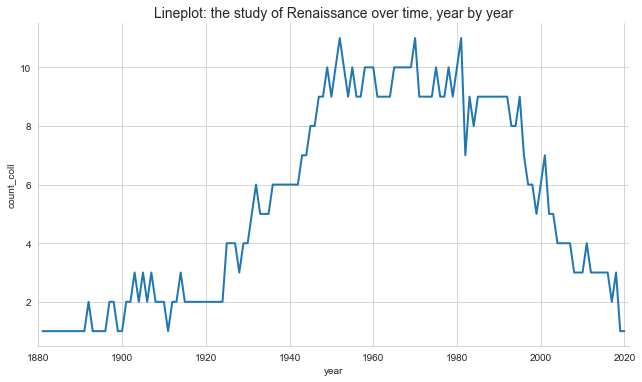

In [14]:
sns.set_style("whitegrid")
all_dates_pl = sns.relplot(x="year", y="count_coll", height=5, aspect=1.75, linewidth=2,
                    kind="line", data=all_dates_grouped);
all_dates_pl.set(xlim=(1880, 2021))
plt.title("Lineplot: the study of Renaissance over time, year by year", size = 14) 

DATA ANALYSIS BY DECADES: Creation of the decade column and computation of the mean of the historian number in that decade

    1. Creatin of the column decade and computation of the decades

In [104]:
data = {'year':all_dates_grouped['year'], 
        'decade':(10 * (all_dates_grouped['year'] // 10)).astype(str) + 's',
        'count_coll':all_dates_grouped['count_coll']} 
decade_df=pd.DataFrame(data)
decade_df['period_label'] = 'Renaissance'
decade_df.head(3)#.loc[decade_df['decade']=='1940s']#.head(3)

,year,decade,count_coll,period_label
0,1881,1880s,1,Renaissance
1,1888,1880s,1,Renaissance
2,1889,1880s,1,Renaissance


    2. Group by decade and compute: 1. the total number of years recorded 2. the total number of historians of each decade

In [83]:
grouped_decades=decade_df.groupby(['decade'], as_index=False).agg({'count_coll':'sum', 'year':'count'})
grouped_decades.columns = ['decade', 'tot_sum', 'year_count']
grouped_decades['period_label'] = 'Renaissance'
grouped_decades.head(3)#.loc[grouped_df['Artistic Period']=='Renaissance']

,decade,tot_sum,year_count,period_label
0,1880s,3,3,Renaissance
1,1890s,13,10,Renaissance
2,1900s,22,10,Renaissance


    3. Compute the mean of the art historians working in all the years recorded for each decade

In [174]:
grouped_decades['avg'] = (grouped_decades['tot_sum']/grouped_decades['year_count']).round(3)
grouped_decades.head(3)#.loc[grouped_df['Artistic Period']=='Renaissance']

,decade,tot_sum,year_count,period_label,avg
0,1880s,3,3,Renaissance,1.0
1,1890s,13,10,Renaissance,1.3
2,1900s,22,10,Renaissance,2.2


In [172]:
# profiling
pp.ProfileReport(grouped_decades)

GRAPHS BY DECADES

    1. SCATTERPLOT (with attention to mean and dispersion)

Text(0.5, 1.0, 'Scatterplot: the study of Renaissance over decades')

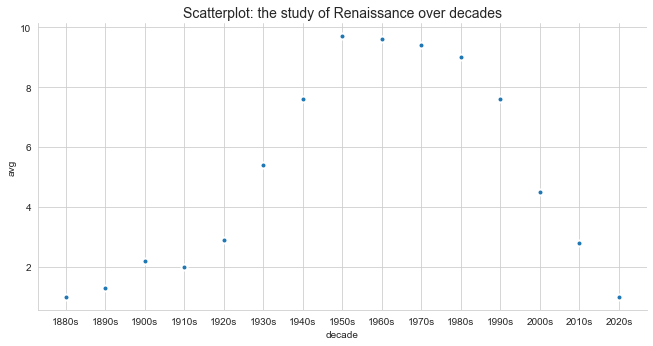

In [175]:
all_dates_pl = sns.relplot(x="decade", y="avg", height=4.5, aspect=2, linewidth=2,
                    kind="scatter", data=grouped_decades);
plt.title("Scatterplot: the study of Renaissance over decades", size = 14) 

    2. LINEPLOT (with attention to the mean distribution over the decades)

Text(0.5, 1.0, 'Lineplot with mean and markers: the study of Renaissance over decades')

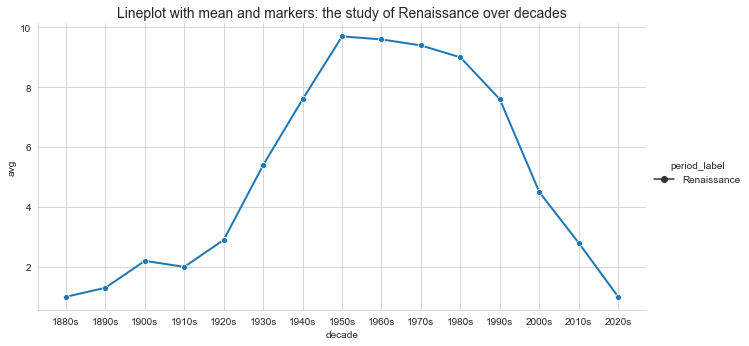

In [101]:
all_dates_pl = sns.relplot(x="decade", y="avg", height=4.5, aspect=2, linewidth=2,
                    kind="line", data=grouped_decades, style='period_label', markers=True, dashes=False);
plt.title("Lineplot with mean and markers: the study of Renaissance over decades", size = 14)

    3. LINEPLOT (with attention to the mean, maximum and minimum distribution over the decades) 

Text(0.5, 1.0, 'Lineplot with aggregation: the study of Renaissance over decades')

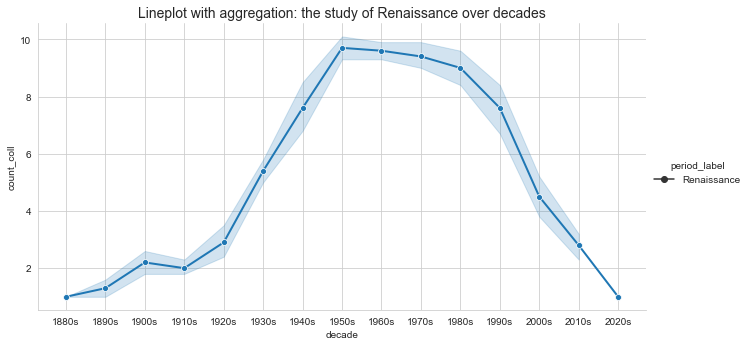

In [102]:
all_dates_pl = sns.relplot(x="decade", y="count_coll", style="period_label", kind='line', markers=True, 
                           dashes=False, height=4.5, aspect=2, linewidth=2, data=decade_df);
plt.title("Lineplot with aggregation: the study of Renaissance over decades", size = 14)

    4. BARPLOT (with attention to the level of each single decade and the focus on the historians)
        To give importance to the single authors a plot which allows to see which authors per decade.

Text(0.5, 1.0, 'Bar Plot with the study of Renaissance over decades')

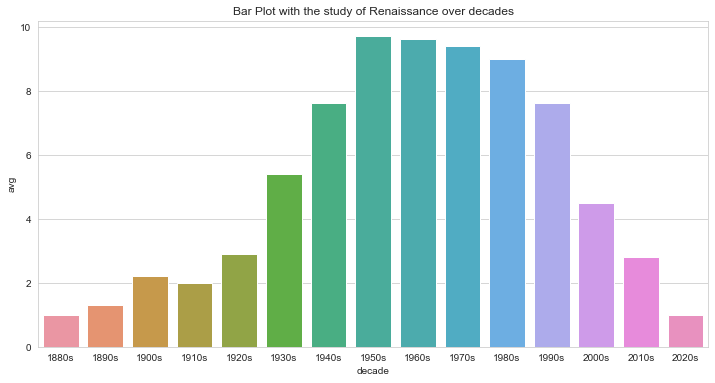

In [103]:
plt.figure(figsize = (12,6))
sns.barplot(x="decade", y="avg", data=grouped_decades)
plt.title("Bar Plot with the study of Renaissance over decades")

#### QUESTION 2

Are the art historians studying renaissance also studying other artistic periods? Consider this question over time, so look at the trend of correlations.

PROCEEDING

    1. Merge 2 files, one from artchives and the other with information retrieved from other databases;
    2. analysis and graphs of the data during time
        1.1 analysis with Renaissance
            1.1.1 analysis by single historic periods
            1.1.2 analysis by all historic periods
        1.2 analysis without Renaissance
    3. analysis and graphs of the correlation of each historic period with Renaissance

VARIABLES

    1. CATEGORICAL: all other artistic periods (from csv);
    2. CATEGORICAL: time periods (per decade);
    3. ORDINAL: time periods (per year);
    4. NUMERIC: number of authors studying artistic periods in a time unit.

GRAPHICS

    - relational plot with line (linechart)
    - heatmap (for correlation)

ANALYSIS OF THE ARTISTIC PERIODS OVER TIME

    1. INTRODUCTION AND MERGE OF THE FILES
    
            1.1 Introduction of the file to merge

In [24]:
extern_df = pd.read_csv('subjects/all_periods_with_renaissance.csv', sep=',', header=0)
extern_df.loc[extern_df['year']<1800]#.loc[extern_df['year'].isnull()]

,historian,period_label,interest,year,publication_title
465,Richard Krautheimer,medieval art,medieval art,1042,"Introduction à une ""iconographie de l'archite..."


            1.2 Clean the file (remove and transform elments)

In [25]:
extern_to_add=extern_df.drop(columns=['interest', 'publication_title'])
extern_to_add.drop(extern_to_add[extern_to_add['year'] < 1700].index, inplace = True)
extern_to_add['year'] = extern_to_add['year'].astype(str).replace('\.0', '', regex=True)
extern_to_add['year'] = extern_to_add['year'].astype(int)
extern_to_add.head(3)#.loc[extern_to_add['year']<1900]

,historian,period_label,year
0,Fritz Heinemann,Baroque,1965
1,John Pope-Hennessy,Renaissance,1979
2,Wolfgang Lotz,Mannerism,1938


            1.3 Merge the two files

In [26]:
all_dates_periods=final_time_df.append(extern_to_add, ignore_index=True)
all_dates_periods=all_dates_periods.sort_values(['historian', 'year'])
all_dates_periods=all_dates_periods.drop_duplicates()
all_dates_periods=all_dates_periods.reset_index(drop=True)
print('The Artchive df has been increased with ', len(all_dates_periods)-len(final_time_df), 'values')
all_dates_periods.head(3)#.loc[all_dates_periods['year']<1800]

The Artchive df has been increased with  320 values


,historian,period_label,year
0,Aby Warburg,Renaissance,1892
1,Aby Warburg,Renaissance,1903
2,Aby Warburg,Renaissance,1904


    2. ANALYSIS WITH RENAISSANCE
    
        2.1 Computation of the number of art historians studying a historic period in a specific year

In [31]:
data_by_year = all_dates_periods.groupby( ["period_label", "year"] ).size().reset_index()#group by period+year
data_by_year.columns = ["period_label", "year", "count_coll"] #rename columns
data_by_year.head(3)

,period_label,year,count_coll
0,14th century,1958,1
1,14th century,1965,1
2,14th century,1966,1


        2.2 Profiling with pandas

In [1]:
# profiling
pp.ProfileReport(data_by_year)

    3. GRAPHS

        3.1 Single historic periods

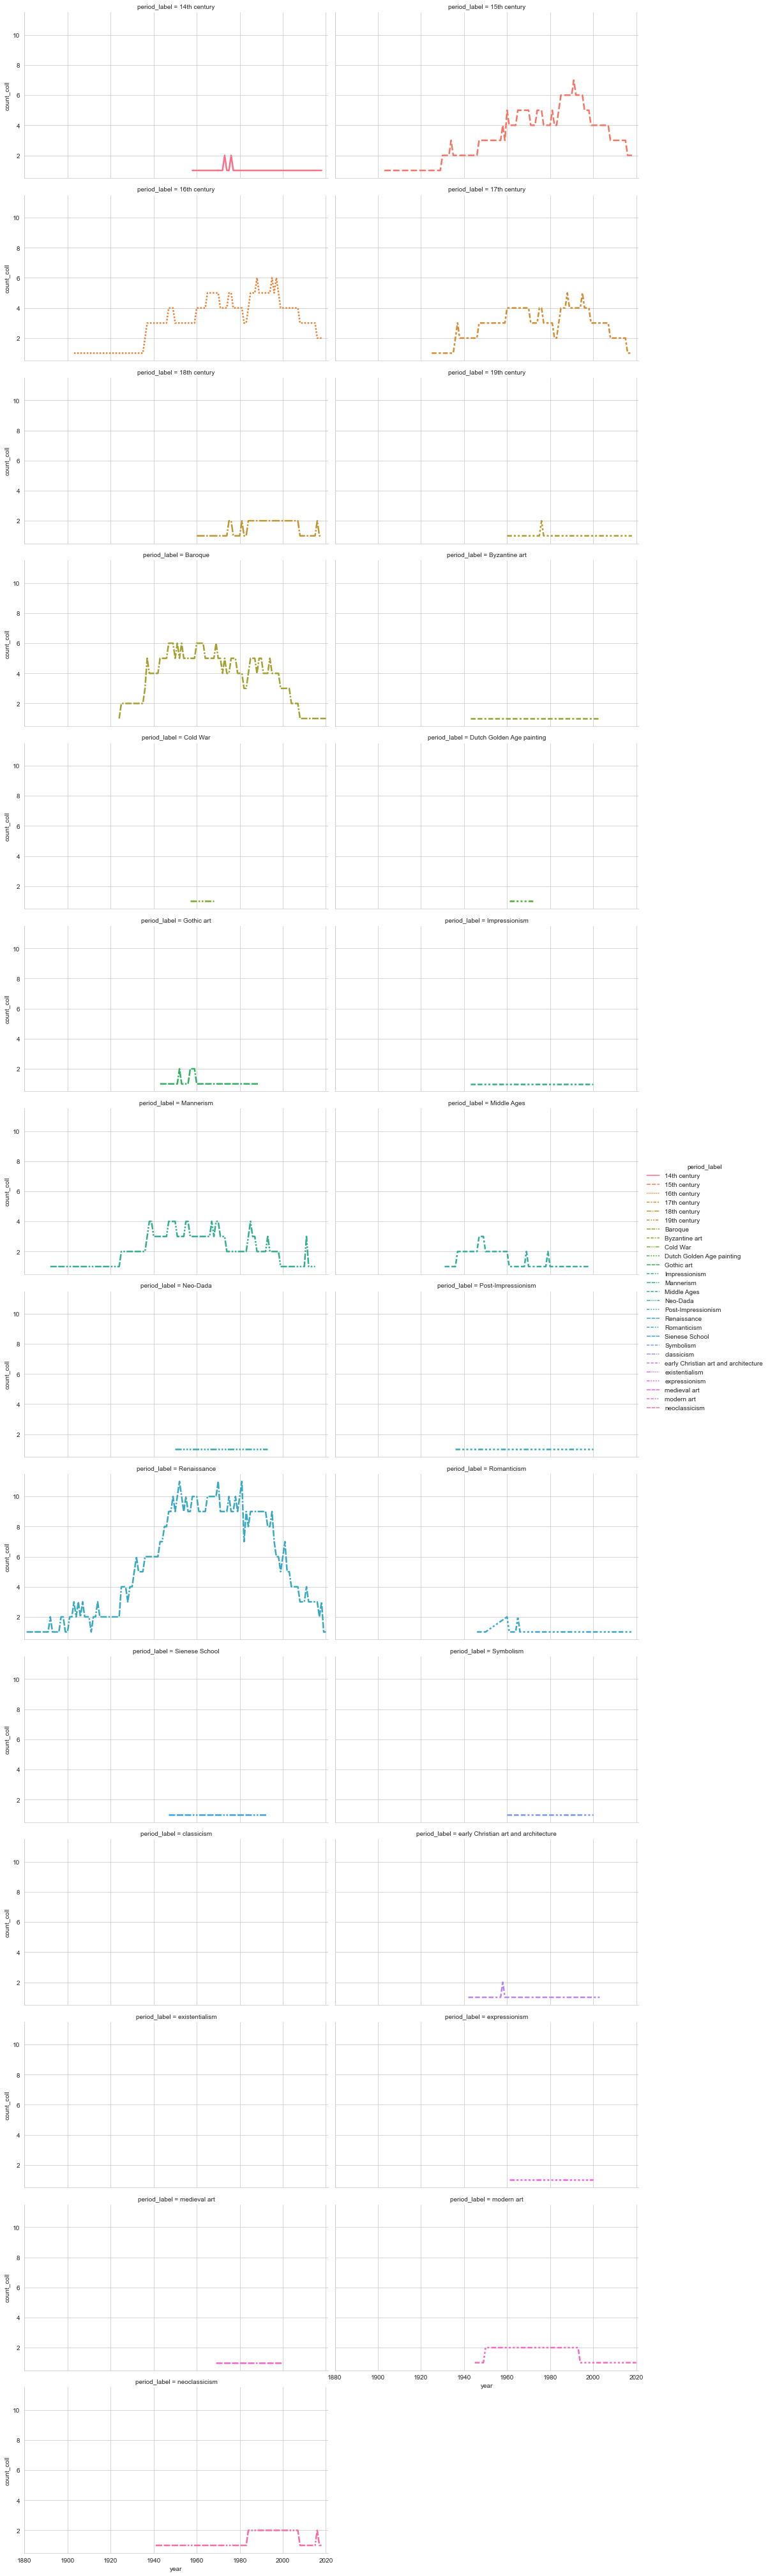

In [118]:
single_plot = sns.relplot(x="year", y="count_coll", hue="period_label", style="period_label",
            col="period_label", col_wrap=2, height=4, aspect=1.75, linewidth=2.5, kind="line", data=data_by_year);

single_plot.set(xlim=(1880, 2021)) # x set to year 1880

        3.1.1Remove the historic periods of which only one date is recorded

In [29]:
data_by_year=data_by_year.loc[~(data_by_year['period_label']=='existentialism')]
data_by_year=data_by_year.loc[~(data_by_year['period_label']=='classicism')]
data_by_year.head(3)#.loc[data_by_year['period_label']=='classicism']

,period_label,year,count_coll
0,14th century,1958,1
1,14th century,1965,1
2,14th century,1966,1


        3.2 All historic periods

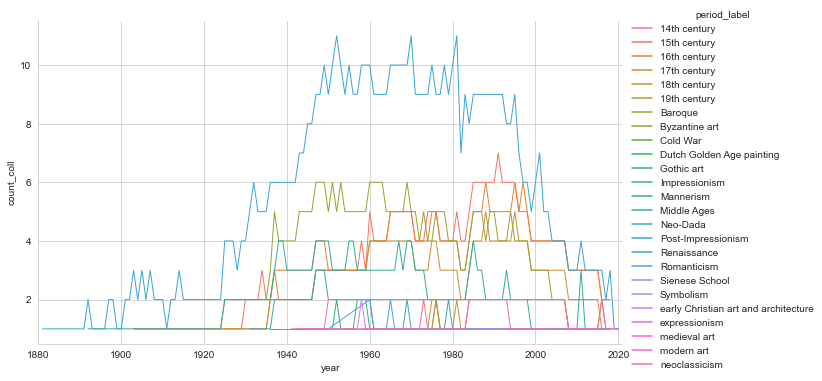

In [137]:
my_pl = sns.relplot(x="year", y="count_coll", hue="period_label", height=5, aspect=1.75, linewidth=1,
            kind="line", data=data_by_year);

my_pl.set(xlim=(1880, 2021))

    4. ANALYSIS WITHOUT RENAISSANCE

In [30]:
no_renaissance = data_by_year.loc[~(data_by_year["period_label"]=="Renaissance")]
print('sum of renaiss cells:', len(data_by_year.loc[data_by_year["period_label"]=="Renaissance"]))
no_renaissance.head(3)

sum of renaiss cells: 134


,period_label,year,count_coll
0,14th century,1958,1
1,14th century,1965,1
2,14th century,1966,1


    5. GRAPH WITHOUT RENAISSANCE

        Historic periods without Renaissance

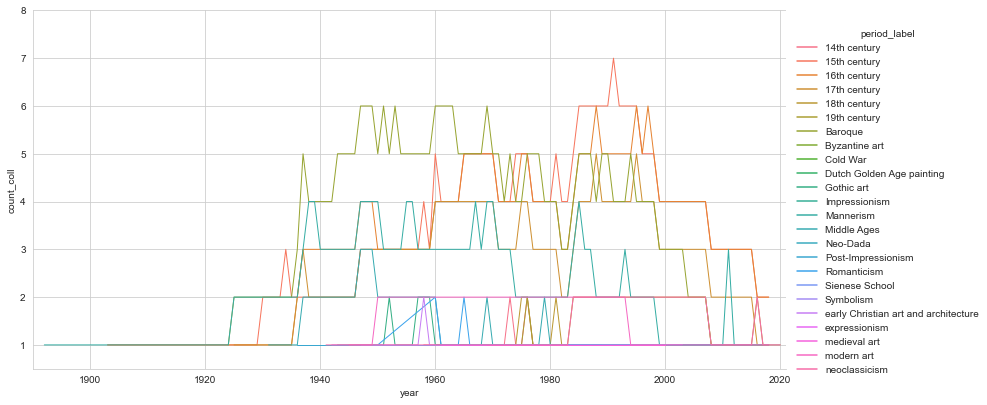

In [150]:
my_pl = sns.relplot(x="year", y="count_coll", hue="period_label", height=5.5, aspect=2, linewidth=1, 
                    kind="line", data=no_renaissance);

my_pl.set(xlim=(1890, 2021))
my_pl.set(ylim=(0.5,8))

CORRELATION OVER TIME

    Heatmap:
    - x axys, years 10 by 10 (consideration derivable from the previous graph)
    - y axis, historic periods
    - colors, number of art historians studying that period in those twenty years

    1. DATA ANALYSIS
    
        1.1 Creation of a new column for the decades

In [32]:
mean_df=pd.DataFrame()
mean_df['a'] = data_by_year['period_label']
mean_df['b']=data_by_year['year']
mean_df['c'] = (10 * (data_by_year['year'] // 10)).astype(str)
mean_df['d']=data_by_year['count_coll']

mean_df.loc[mean_df['a']=='Renaissance'].head(3)

,a,b,c,d
936,Renaissance,1881,1880,1
937,Renaissance,1888,1880,1
938,Renaissance,1889,1880,1


        1.2 Computation of the mean for the heatmap
    
            1.2.1 Sum of the authors studying the artistic periods per decade

In [33]:
grouped_df=mean_df.groupby(['a', 'c'], as_index=False).agg({'d':'sum', 'b':'count'})
grouped_df.columns = ['Artistic Period', 'Timespan', 'Art historians', 'years']
grouped_df['Artistic Period']=grouped_df['Artistic Period'].str.capitalize()
grouped_df.loc[grouped_df['Artistic Period']=='expressionism']

,Artistic Period,Timespan,Art historians,years


            1.2.2 Average of the authors studying the artistic periods per decade ('Art historians' // 'years')

In [34]:
grouped_df['avg'] = (grouped_df['Art historians']/grouped_df['years']).round(3)
grouped_df.loc[grouped_df['avg']==1.833].head(3)

,Artistic Period,Timespan,Art historians,years,avg
51,Baroque,1920,11,6,1.833
86,Mannerism,1920,11,6,1.833


            1.2.3 Small changes to grouped_df to create the json for the final barchart

In [35]:
file_for_heatmap=grouped_df.drop(columns=['Art historians', 'years'])
#file_for_heatmap.to_csv('Json_to_Sara/heatmap2.csv', index=False)
#file_for_heatmap

        1.3 creation of the lists to check the material for a pivot

In [276]:
all_periods=grouped_df.groupby(['Artistic Period'], as_index=False).agg({'Timespan':'count'})
artistic_list=grouped_df['Artistic Period'].unique()
timespans_list=grouped_df['Timespan'].unique()

all_periods.head(3)
#timespans_list

,Artistic Period,Timespan
0,14th century,7
1,15th century,11
2,16th century,11


In [278]:
# profiling
pp.ProfileReport(grouped_df)

    2. PIVOT (Creation of the pivot and addiction of the zeros where missing values)

In [36]:
date_pivot = grouped_df.pivot(index = 'Artistic Period', columns = 'Timespan', 
                      values = 'avg').fillna(0)
date_pivot

    3. GRAPH

        Heatmap

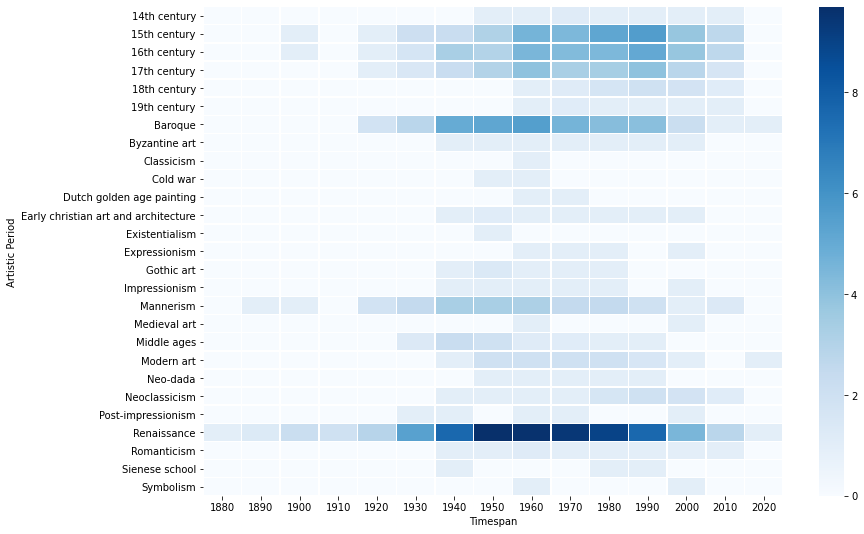

In [37]:
plt.figure(figsize = (13,9))
ax = sns.heatmap(date_pivot, linewidths=.5, cmap="Blues")
ax

#### QUESTION 3

Are there aspects of the Renaissance that have been studied more by historians? Please define aspects, e.g. artists, artworks, genres, etc

PROCEEDING:

    1. Understanding data and variables:
        1.1 define the aspects of art studied by art historians:
            - artists: hasSubjectArtist (+ artist subtypes)
            - artworks: hasSubjectArtwork
            - genre: hasSubjectGenre (+ genre subtypes)
        1.2 count how many times art historians study a specific aspect: 
            - method sum() on the column type of interest
        
    2. Data analysis and graphs for the single art historians
    3. Data analysis and graphs for all the occurencies without subtypes
    4. Data analysis and graphs for all the occurencies with subtypes
    5. Data analysis and graphs for the most studyied contents (excluding general references to Renaissance)
    
VARIABLES:

    - NOMINAL: aspects studied
    - NUMERIC: number of art historians

GRAPHICS:

    - BARCHART (total number of occurencies)
    - PIECHART (percentage)
    - BOXPLOT (to find maximum, minimum, mean and outliers)

SINGLE OCCURENCIES

    1. ANALYSIS

        1.1 Introduction of the file and data filtering

In [38]:
aspects_df = pd.read_csv('subjects/renaissance_subjects.csv', sep=',', header=0)
aspects_df = aspects_df.drop_duplicates()
aspects_df = aspects_df.sort_values(by='historian').reset_index(drop=True)
aspects_df.loc[aspects_df['interest']=='Cellini'].head(3)

,historian,interest,type


        1.2 Analysis of the interest types by single authors

In [39]:
interest_types=aspects_df['type'].unique()
interest_types

array(['person', 'artifact', 'genre'], dtype=object)

In [41]:
single_historians=aspects_df['historian'].unique()
print(len(single_historians))#, single_historians)

18


        1.3 New df by the grouping of historians and number of occurencies for the respective interests

In [42]:
count_type = aspects_df.groupby(['historian', 'type']).size().reset_index()
count_type.columns=['historian', 'type', 'count_coll']
count_type.head(3)

,historian,type,count_coll
0,Aby Warburg,artifact,2
1,Aby Warburg,genre,3
2,Aby Warburg,person,3


    2. GRAPHS
        2.1 BARPLOTS

<Figure size 1800x576 with 0 Axes>

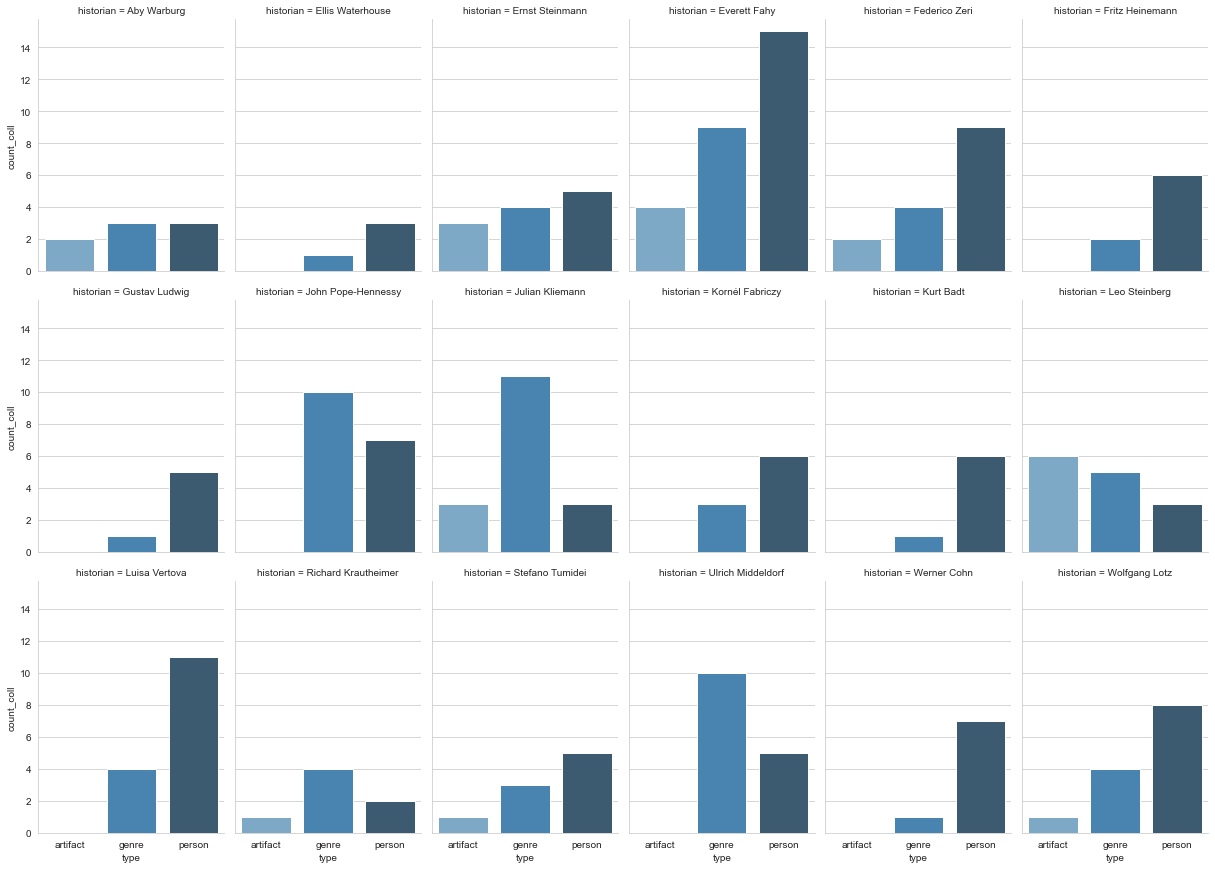

In [181]:
plt.figure(figsize = (25,8))
sns.catplot(x="type", y="count_coll", col="historian", data=count_type, kind="bar", col_wrap=6, height=4, 
            aspect=.7, palette="Blues_d");

        2.2 PIECHARTS

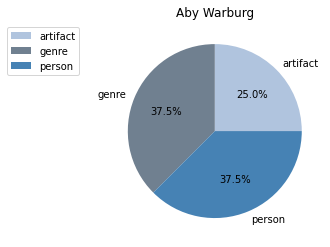

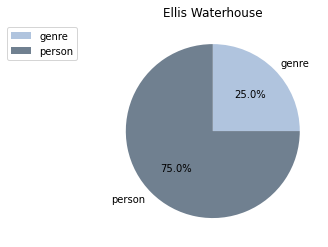

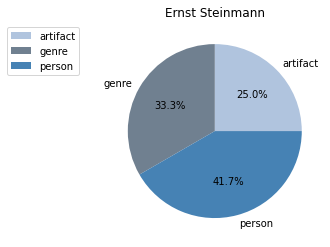

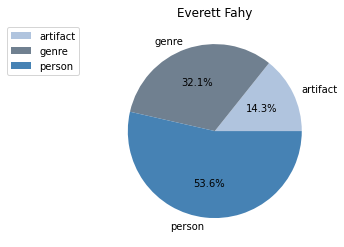

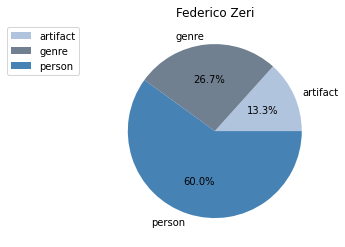

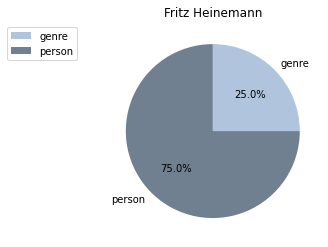

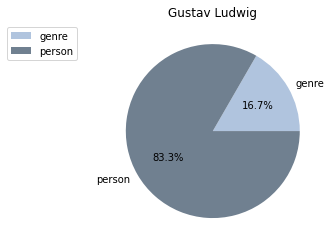

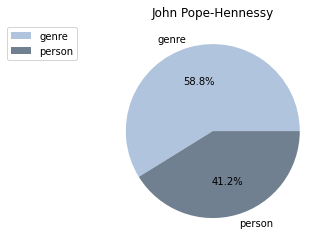

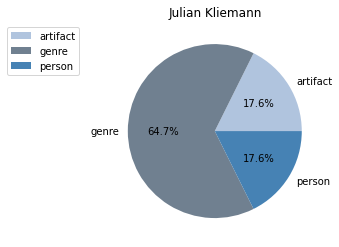

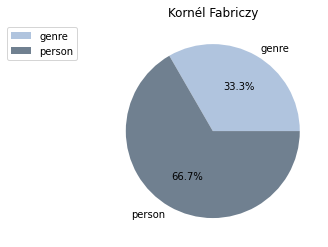

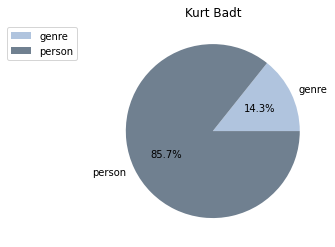

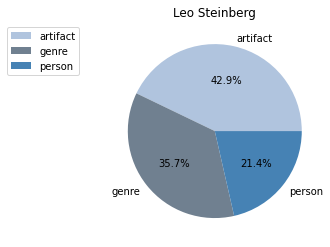

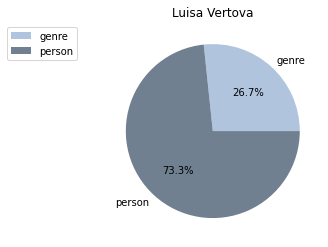

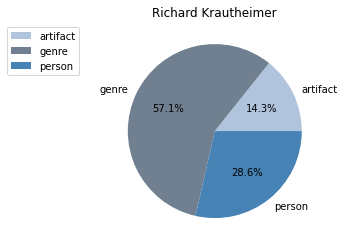

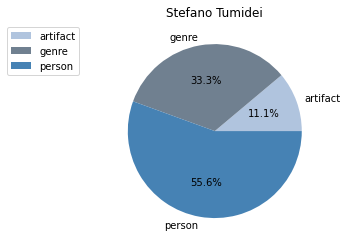

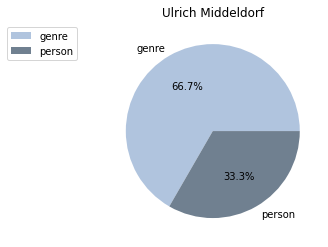

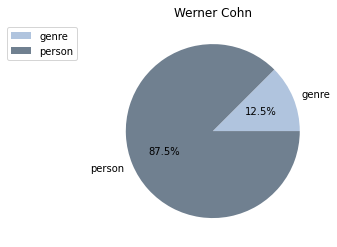

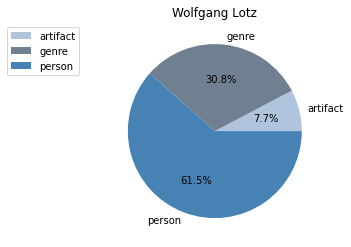

In [43]:
for name in single_historians: #forloop to apply the piechart to every historian
    single_df=count_type.loc[count_type['historian']==name]
    fig, axs = plt.subplots()
    axs.pie(single_df['count_coll'], labels=single_df['type'], autopct='%1.1f%%', 
            colors=['lightsteelblue', 'slategrey', 'steelblue'])
    axs.legend(loc='upper right', bbox_to_anchor=(-0.1, 1))
    axs.set(title=name)
    plt.show()

ALL OCCURENCIES WITHOUT SUBTYPES

    GRAPHS
    
        1. BARPLOT

Text(0.5, 1.0, 'Bar Plot with all the historians')

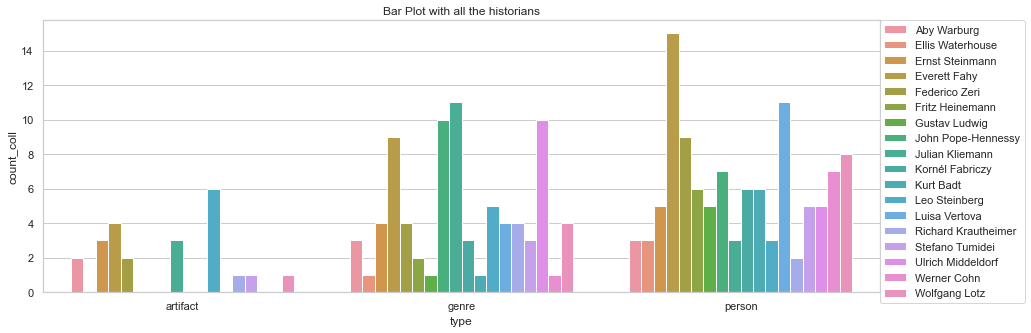

In [44]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,5))
sns.barplot(x="type", y="count_coll", hue="historian", data=count_type)#, palette="Blues_d")
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
plt.title("Bar Plot with all the historians")

        2. BOXPLOT (check the MEAN, the MAXIMUM, the MINIMUM and the OUTLIERS)

Text(0.5, 1.0, 'Box Plot with all the historians')

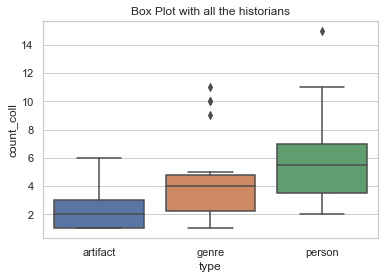

In [45]:
sns.boxplot(x="type", y="count_coll", data=count_type)
plt.title("Box Plot with all the historians")

        3. PIECHART

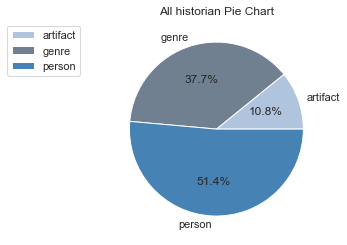

<Figure size 1440x360 with 0 Axes>

In [46]:
percent_df=count_type.groupby(['type'], as_index=False).agg({'count_coll':'sum'})
fig, axs = plt.subplots()
axs.pie(percent_df['count_coll'], labels=percent_df['type'], autopct='%1.1f%%', 
        colors=['lightsteelblue', 'slategrey', 'steelblue'])
axs.legend(loc='upper right', bbox_to_anchor=(-0.1, 1))
axs.set(title='All historian Pie Chart')
plt.figure(figsize = (20,5))
plt.show()

ALL OCCURENCIES WITH SUBTYPES

    1. DATA ANALYSIS

        1.1 Introduction of the file with types and subtypes and data filtering

In [59]:
subtypes_df = pd.read_csv('subjects/renaissance_subjects_subtypes.csv', sep=',', header=0)
subtypes_df = subtypes_df.drop_duplicates()
subtypes_df = subtypes_df.sort_values(by='historian').reset_index(drop=True)
interest_types=subtypes_df['subtype'].unique() #distinzione tra subject object e subject genre
subtypes_df#.head(3)#.loc[subtypes_df['interest']=='Michelangelo'].head(3)

,historian,interest,type,subtype
0,Aby Warburg,Sandro Botticelli,person,artist
1,Aby Warburg,Sandro Botticelli,person,painter
2,Aby Warburg,Leonardo da Vinci,person,caricaturist
3,Aby Warburg,Villa Medici,artifact,building
4,Aby Warburg,Italian Renaissance,"genres, materials, techniques",genre
...,...,...,...,...
312,Wolfgang Lotz,Michelangelo,person,sculptor
313,Wolfgang Lotz,Michelangelo,person,draftsperson
314,Wolfgang Lotz,Leon Battista Alberti,person,painter
315,Wolfgang Lotz,Leonardo da Vinci,person,sculptor


In [66]:
only_subtypes=subtypes_df.loc[~(subtypes_df['subtype'].isnull())] #df only with cells containing subtypes
only_subtypes=only_subtypes.reset_index(drop=True) #reindexing
no_subtypes = subtypes_df.loc[subtypes_df['subtype'].isnull()] #df with only 'subtype' nan, just to check values

#print(only_subtypes)
#print(' ')
#print(no_subtypes)
len(only_subtypes.loc[only_subtypes['type']=='artifact'])

24

In [64]:
grouped_subtypes=only_subtypes.groupby(['subtype']).size().reset_index()
grouped_subtypes.columns=['subtype', 'count_coll']
print(grouped_subtypes['count_coll'].sum())#.head(3)
grouped_subtypes

314


,subtype,count_coll
0,architect,37
1,artist,10
2,artwork,6
3,building,18
4,caricaturist,5
5,ceramicist,1
6,draftsperson,7
7,drawer,9
8,engraver,3
9,genre,43


    2. GRAPHS

        2.1 BARPLOTS

            2.1.1 Barplot for all the subtypes

Text(0.5, 1.0, 'Bar Plot with all subtypes')

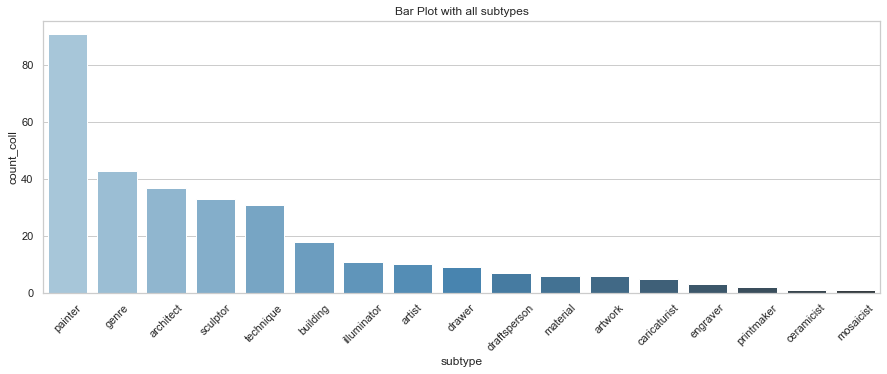

In [51]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,5))
plt.xticks(rotation=45)
sns.barplot(x="subtype", y="count_coll", data=grouped_subtypes.sort_values(['count_coll'], ascending=False), 
            palette="Blues_d")
plt.title("Bar Plot with all subtypes")
#plt.yscale('log')
#plt.grid(which='minor')

            2.1.2 Barplot for the genre/technique/material subtypes
            
                2.1.2.1 Creation of a new df with only the genre/technique/material subtypes

In [69]:
genre_df=only_subtypes.loc[only_subtypes['type']=='genres, materials, techniques']
group_genre=genre_df.groupby('subtype').size().reset_index()
group_genre.columns=['subtype', 'count_coll']
group_genre=group_genre.sort_values(['count_coll'], ascending=False)
#group_genre.to_csv('chart_to_q3.csv', index=False)
#group_genre['count_coll'].sum()
print(group_genre['count_coll'].sum())
group_genre

80


,subtype,count_coll
0,genre,43
2,technique,31
1,material,6


                2.1.2.2 Graph

Text(0.5, 1.0, 'Bar Plot with only genre/technique/material subtypes')

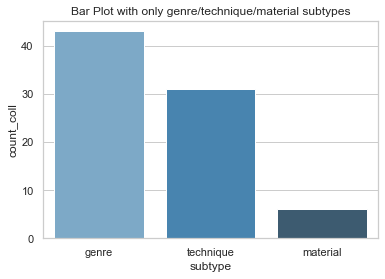

In [70]:
sns.barplot(x="subtype", y="count_coll", data=group_genre, 
            palette="Blues_d")
plt.title("Bar Plot with only genre/technique/material subtypes")

        2.1.3 Barplot for the person subtypes
        
            2.1.3.1 Creation of a new df with only prople subtypes

In [74]:
person_df=only_subtypes.loc[only_subtypes['type']=='person']
group_person=person_df.groupby('subtype').size().reset_index()
group_person.columns=['subtype', 'count_coll']
only_subtypes.loc[only_subtypes['interest']=='Michelangelo'].head(3)
print(group_person['count_coll'].sum())
group_person.head(3)

210


,subtype,count_coll
0,architect,37
1,artist,10
2,caricaturist,5


            2.1.3.2 Graphic

Text(0.5, 1.0, 'Bar Plot with ony person subtypes')

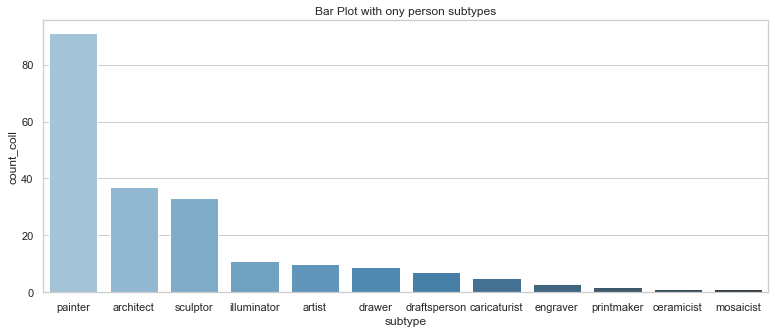

In [75]:
plt.figure(figsize = (13,5))
sns.set_theme(style="whitegrid")
sns.barplot(x="subtype", y="count_coll", data=group_person.sort_values(['count_coll'], ascending=False), 
            palette="Blues_d")
plt.title("Bar Plot with ony person subtypes")

    2.2 PIECHARTS
    
        2.2.1.1 Data analysis to creat a df with a 'other' category for subtypes with occurence <= 7

In [206]:
row_to_add=grouped_subtypes.loc[grouped_subtypes['count_coll']<=7] #df for rows with count_coll <=6
count_to_add=row_to_add['count_coll'].sum() #sum of the total values of the column count_coll in row_to_add
pie_subtypes=grouped_subtypes.loc[~(grouped_subtypes['count_coll']<=7)]

df2 = pd.DataFrame({"subtype":['other'], "count_coll":[count_to_add]}) # create a second df using dictionary 
pie_subtypes=pie_subtypes.append(df2, ignore_index=True)
pie_subtypes=pie_subtypes.sort_values(by=['count_coll']).reset_index(drop=True)

count_to_add
pie_subtypes.head(3)

,subtype,count_coll
0,drawer,9
1,artist,10
2,illuminator,11


        2.2.1.2 Pie chart of all the subtypes

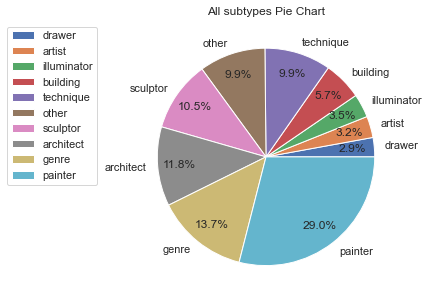

In [208]:
fig, axs = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
axs.pie(pie_subtypes['count_coll'], labels=pie_subtypes['subtype'], autopct='%1.1f%%', pctdistance=0.8)
axs.legend(loc='upper right', bbox_to_anchor=(-0.1, 1))
axs.set(title='All subtypes Pie Chart')
plt.show()

        2.2.2 Pie chart of the genre/technique/material subtypes

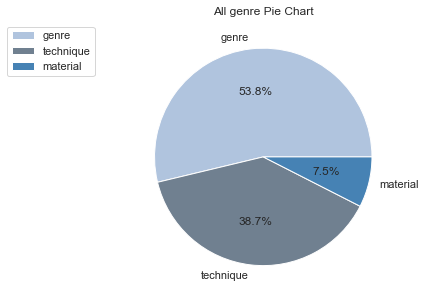

In [209]:
fig, axs = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
axs.pie(group_genre['count_coll'], labels=group_genre['subtype'], autopct='%1.1f%%', 
        colors=['lightsteelblue', 'slategrey', 'steelblue'])
axs.legend(loc='upper right', bbox_to_anchor=(-0.1, 1))
axs.set(title='All genre Pie Chart')
plt.show()

        2.2.3.1 Data analysis to create a df with a 'other' category for subtypes with occurence <= 7

In [215]:
only_relevant=group_person.loc[group_person['count_coll']<=7] #df for rows with count_coll <=7
count_rel=only_relevant['count_coll'].sum() #sum the values of count_coll cells to have a total value of 'others'
pie_people=group_person.loc[~(group_person['count_coll']<=7)] #remove rows with count_coll <=7 from the main df

#create a df to add to the original df
df3 = pd.DataFrame({"subtype":['other'], "count_coll":[count_rel]}) 
pie_people=pie_people.append(df3, ignore_index=True) #add the new df to the main one
pie_people=pie_people.sort_values(by=['count_coll']).reset_index(drop=True) #sort values by count_coll
pie_people.head(3)

,subtype,count_coll
0,drawer,9
1,artist,10
2,illuminator,11


        2.2.3.2 Pie chart of the person subtypes

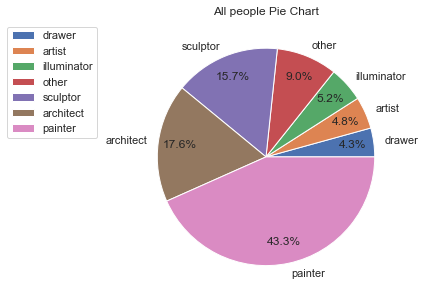

In [214]:
fig, axs = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
axs.pie(pie_people['count_coll'], labels=pie_people['subtype'], autopct='%1.1f%%', pctdistance=0.8)
axs.legend(loc='upper right', bbox_to_anchor=(-0.1, 1))
axs.set(title='All people Pie Chart')
plt.show()

THE INTERESTS MOST APPRECIATED BY ART HISTORIANS

    1. DATA ANALYSIS
        1.1 grouping only_subtypes by historian and subtype

In [218]:
hist_subtypes=only_subtypes.groupby(['historian', 'interest']).size().reset_index()
hist_subtypes.columns=['historian', 'interest', 'count_coll']
hist_subtypes=hist_subtypes.sort_values(by='count_coll', ascending=False).reset_index(drop=True)

hist_subtypes.loc[hist_subtypes['interest'].str.contains('Renaissance'), 'interest'] = 'General Interest'
hist_subtypes.head(3)#.loc[hist_subtypes['interest'].str.contains('General Interest')]

,historian,interest,count_coll
0,Werner Cohn,Albrecht Durer,5
1,Everett Fahy,Leonardo da Vinci,4
2,Wolfgang Lotz,Leonardo da Vinci,4


        1.2 Grouping and ordering by interest, from the most studied

In [219]:
grouped_interest=hist_subtypes.groupby(['interest']).size().reset_index()
grouped_interest.columns=['interest', 'count_coll']
grouped_interest=grouped_interest.sort_values(by='count_coll', ascending=False).reset_index(drop=True)
relevant_interests=grouped_interest.loc[grouped_interest['count_coll']>=3]
relevant_interests.head(3)

,interest,count_coll
0,General Interest,75
1,Michelangelo,7
2,Sandro Botticelli,6


        1.3 Too many general interest, need to remove that column

In [220]:
final_relevant_interests=relevant_interests.loc[~(relevant_interests['interest']=='General Interest')]
final_relevant_interests.head(3)

,interest,count_coll
1,Michelangelo,7
2,Sandro Botticelli,6
3,Titian,6


    2. GRAPH
    
        BAR PLOT

Text(0.5, 1.0, 'Bar Plot with ony person subtypes')

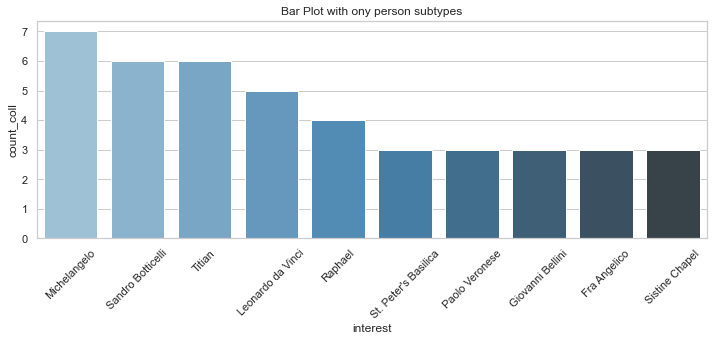

In [221]:
plt.figure(figsize = (12,4))
plt.xticks(rotation=45)
sns.set_theme(style="whitegrid")
sns.barplot(x="interest", y="count_coll", data=final_relevant_interests, palette="Blues_d")
plt.title("Bar Plot with ony person subtypes")

#### QUESTION 4

Which types of resources in archival collections represent the study of the Renaissance? Where are the sources?

PROCEEDING

    1. Which types of resources in archival collections represent the study of the Renaissance?
        1.1 Analyze both other and main subject object to know all the materials
        1.2 Analyze only main object types, to know which are the most representative materials
        
    2. Where are the sources?
        2.1 Sum all the occurencies of the single archive (study the distribution of the materials among the keepers/archives)

DATA

    - NOMINAL: the historian archives names
    - NOMINAL: the object types labels
    - NUMERIC: the number of objects mentioned per type
    - NUMERIC: the number of times each archive is mentioned for a different object

GRAPHS

    - BARPLOT (for comparison and composition)
    - PIE/DONUT CHART
    - HEATMAP

WHICH RESOURCES REPRESENT THE STUDY OF RENAISSANCE

    1. ALL THE RESOURCES
    
        1.1 Analyze both the main objects and the less relevant ones to know all the materials

            1.1.1 Add, sort and clean the csv file

In [192]:
all_resources_df = pd.read_csv('subjects/object_types2.csv', sep=',', header=0)
all_resources_df=all_resources_df.drop_duplicates()
all_resources_df=all_resources_df.sort_values(['subject'], ascending=[True]).reset_index(drop=True)
all_resources_df.loc[all_resources_df['hasOtherObjectType']=='note']

,subject,hasOtherObjectType
9,Fondo Aby Warburg,note
26,Gustav Ludwig-Vermächtnis,note


            1.1.2 Unify all the different occurencies of 'notes' and 'typescript'

In [193]:
all_resources_df['hasOtherObjectType']=all_resources_df['hasOtherObjectType'].str.replace('Notes', 'notes')
all_resources_df['hasOtherObjectType']=all_resources_df['hasOtherObjectType'].str.replace('TypeScript', 
                                                                                          'typescript')
all_resources_df.loc[all_resources_df['hasOtherObjectType']=='note', 'hasOtherObjectType'] = 'notes'

all_resources_df.loc[all_resources_df['hasOtherObjectType']=='notes']#.head(3)


,subject,hasOtherObjectType
9,Fondo Aby Warburg,notes
26,Gustav Ludwig-Vermächtnis,notes
38,Nachlass Cornelius von Fabriczy,notes
42,"Nachlass Fritz Heinemann, Notizen zur venezian...",notes
49,Nachlass Kurt Badt,notes
60,Nachlass Ulrich Middeldorf,notes


            1.1.3 Group all resources by object type, and count the occurencies of each type

In [143]:
grouped_resources=all_resources_df.groupby(['hasOtherObjectType']).size().reset_index()
grouped_resources.columns = ['ObjectType', 'count_coll']
grouped_resources=grouped_resources.sort_values(['count_coll'], ascending=[False]).reset_index(drop=True)
#grouped_resources.to_csv('resources_for_barchart.csv', index=False)
#grouped_resources.loc[grouped_resources['ObjectType']=='notes']#.head(3)
grouped_resources['count_coll'].sum()

71

        1.2 Plots
    
            1.2.1 BAR PLOT

Text(0.5, 1.0, 'Bar Plot with all object types')

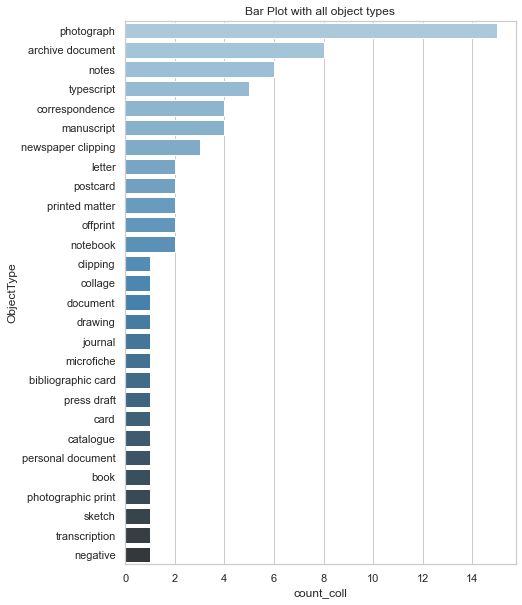

In [144]:
plt.figure(figsize = (7,10))
sns.barplot(x="count_coll", y="ObjectType", data=grouped_resources.sort_values(['count_coll'], ascending=False), 
            palette="Blues_d")
plt.title("Bar Plot with all object types")

        1.2.2 PIE CHART 
       
            1.2.2.1 Group objects with one or two occurrences in single values

In [90]:
pie_objects=grouped_resources.loc[grouped_resources['count_coll']>2]
for num in range(1,3):
    relevant_objects=grouped_resources.loc[grouped_resources['count_coll']==num] #df for rows with count_coll <=4
    count_rel=relevant_objects['count_coll'].sum()

    df4 = pd.DataFrame({"ObjectType":['tot of '+str(num)+' occurrences'], "count_coll":[count_rel]}) 
    pie_objects=pie_objects.append(df4, ignore_index=True)
    
pie_objects=pie_objects.sort_values(by='count_coll', ascending=True).reset_index(drop=True)
pie_objects.head(3)

,ObjectType,count_coll
0,newspaper clipping,3
1,correspondence,4
2,manuscript,4


            1.2.2.2 PIE CHART

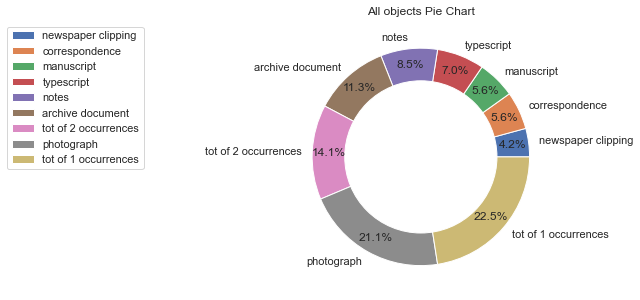

In [86]:
fig, axs = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
axs.pie(pie_objects['count_coll'], labels=pie_objects['ObjectType'], autopct='%1.1f%%', pctdistance=0.85)
axs.legend(loc='upper right', bbox_to_anchor=(-0.5, 1))
axs.set(title='All objects Pie Chart')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white') 
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

        1.2.3 COLUMN CHART (based on the percantages on the total)
        
            1.2.3.1 Computation of the percentage

In [87]:
data_per=pie_objects.groupby('ObjectType').agg(percentage=('count_coll', lambda p:p.sum()/pie_objects['count_coll'].sum()*100)).round(2)
data_per=data_per.sort_values(['percentage'], ascending=[True])
data_per.head(3)


,percentage
ObjectType,
newspaper clipping,4.23
correspondence,5.63
manuscript,5.63


            1.2.3.2 Plot

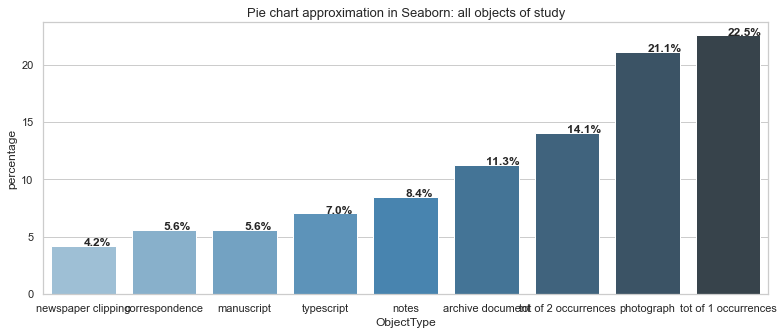

In [88]:
bar,ax = plt.subplots(figsize=(13,5))
ax = sns.barplot(x=data_per.index, y='percentage', data=data_per, palette="Blues_d")
ax.set_title("Pie chart approximation in Seaborn: all objects of study", fontsize=13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),"%.1f%%"% rect.get_height(), weight='bold')
ax

    2. ONLY MAIN SUBJECTS OF THE ARCHIVAL COLLECTIONS
    
        2.1 Analysis of the data

            2.1.1 Read and clean the csv file

In [187]:
resource_rank_df = pd.read_csv('subjects/object_types.csv', sep=',', header=0)
resource_rank_df=resource_rank_df.drop_duplicates()
resource_rank_df=resource_rank_df.sort_values(['subject'], ascending=[True]).reset_index(drop=True)
resource_rank_df.head(3)#.loc[resource1_df['subject'].str.contains('Vertova')]#.head(60)
print(len(resource_rank_df.loc[~(resource_rank_df['hasOtherObjectType'].isnull())]))
resource_rank_df.loc[resource_rank_df['hasMainObjectType']=='note']

22


,subject,hasOtherObjectType,hasMainObjectType
26,Gustav Ludwig-Vermächtnis,NaN,note


            2.1.2 Keep only rows with 'hasMainObjectType' not null

In [188]:
main_object_df=resource_rank_df.loc[~(resource_rank_df['hasMainObjectType'].isnull())].reset_index(drop=True)
main_object_df=main_object_df.drop(columns=['hasOtherObjectType'])
print(len(main_object_df))
main_object_df.head(3)#.loc[main_object_df['hasMainObjectType']=='note']
main_object_df.loc[main_object_df['hasMainObjectType']=='note']

49


,subject,hasMainObjectType
13,Gustav Ludwig-Vermächtnis,note


            2.1.3 Group the different labels 'note', 'notes', 'Note' and 'TypeScript'

In [189]:
main_object_df['hasMainObjectType']=main_object_df['hasMainObjectType'].str.replace('Notes', 'notes')
main_object_df['hasMainObjectType']=main_object_df['hasMainObjectType'].str.replace('TypeScript', 'typescript')
main_object_df.loc[main_object_df['hasMainObjectType']=='note', 'hasMainObjectType'] = 'notes'
main_object_df.loc[main_object_df['hasMainObjectType']=='notes']#.head(3)

,subject,hasMainObjectType
13,Gustav Ludwig-Vermächtnis,notes
22,Nachlass Cornelius von Fabriczy,notes
26,"Nachlass Fritz Heinemann, Notizen zur venezian...",notes
31,Nachlass Kurt Badt,notes
42,Nachlass Ulrich Middeldorf,notes


        2.2 GRAPHS
        
            2.2.1 BARPLOT
            
                2.2.1.1 Analysis for the barplot

In [159]:
main_resources=main_object_df.groupby( ['hasMainObjectType'] ).size().reset_index()
main_resources.columns = ['ObjectType', 'count_coll']
main_resources=main_resources.sort_values(['count_coll'], ascending=[False]).reset_index(drop=True)
main_resources['count_coll'].sum()#.head(3)#.loc[groued_resources['count_coll']>1].head()

49

                2.2.1.2 Plot

Text(0.5, 1.0, 'Bar Plot with all object types')

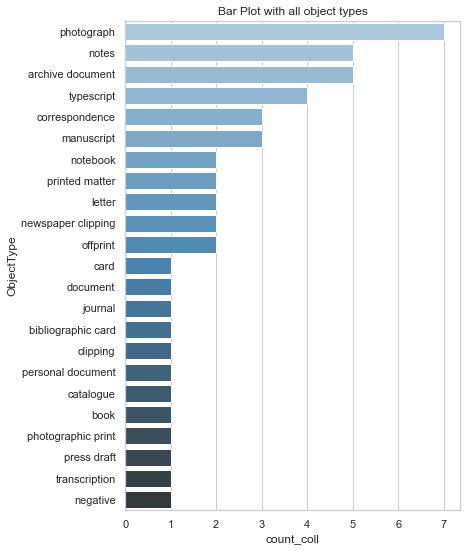

In [160]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,9))
sns.barplot(x="count_coll", y="ObjectType", data=main_resources.sort_values(['count_coll'], ascending=False), 
            palette="Blues_d")
plt.title("Bar Plot with all object types")

        2.2.2 PIE CHART
        
            2.2.2.1 Analysis of the data for a pie chart

In [164]:
new_row=main_resources.loc[main_resources['count_coll']==1] #df for rows with count_coll <=6
cell_to_add=new_row['count_coll'].sum() #sum of the total values of the column count_coll in row_to_add
pie_sub=main_resources.loc[~(main_resources['count_coll']==1)]

df4 = pd.DataFrame({"ObjectType":['other'], "count_coll":[cell_to_add]}) # create a second df using dictionary 
pie_sub=pie_sub.append(df4, ignore_index=True)
pie_sub=pie_sub.sort_values(['count_coll', 'ObjectType'], ascending=[False, True]).reset_index(drop=True)

pie_sub['count_coll'].sum()#.head(3)

49

            2.2.2.2 Graphic

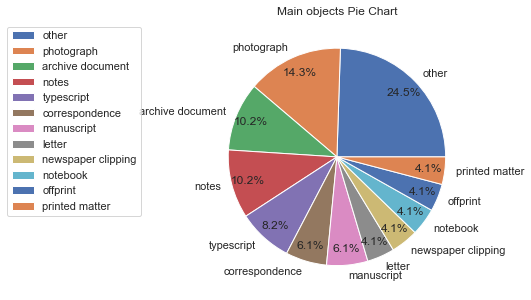

In [165]:
fig, axs = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
axs.pie(pie_sub['count_coll'], labels=pie_sub['ObjectType'], autopct='%1.1f%%', pctdistance=0.85)
axs.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
axs.set(title='Main objects Pie Chart')
plt.show()

WHERE ARE THE RESOURCES?

    1. analysis of the file
    
        1.1 Introduction of the file

In [175]:
keepers_df=pd.read_csv('subjects/object_types_keepers.csv', sep=',', header=0)
print(len(keepers_df['hasObjectType']))
keepers_df.loc[keepers_df['hasObjectType']=='Notes']

71


,keeper,collection,hasObjectType
4,Kunsthistorisches Institut in Florenz,Nachlass Cornelius von Fabriczy,Notes
31,Kunsthistorisches Institut in Florenz,"Nachlass Fritz Heinemann, Notizen zur venezian...",Notes


        1.2 Reorder by keeper + reduced the longest names among them (for better graphic representations)

In [178]:
keepers_df=keepers_df.sort_values(['keeper'], ascending=[True]).reset_index(drop=True)

name_list=[('Bibliotheca Hertziana %u2013 Max Planck Institute of Art History', 'Biblioteca Hertziana'), 
           ('Kunsthistorisches Institut in Florenz', 'Kunsthistorisches Institut')]

for name in name_list:
    keepers_df.loc[keepers_df['keeper']==name[0], 'keeper'] = name[1]
    
print(len(keepers_df['hasObjectType']))
keepers_df.loc[keepers_df['hasObjectType']=='Notes']#.head(3)

71


,keeper,collection,hasObjectType
49,Kunsthistorisches Institut,Nachlass Cornelius von Fabriczy,Notes
69,Kunsthistorisches Institut,"Nachlass Fritz Heinemann, Notizen zur venezian...",Notes


        1.3 Unified objects with different labels, same content

In [181]:
keepers_df['hasObjectType']=keepers_df['hasObjectType'].str.replace('Notes', 'notes')
keepers_df.loc[keepers_df['hasObjectType']=='note', 'hasObjectType'] = 'notes'
keepers_df.loc[keepers_df['hasObjectType']=='TypeScript', 'hasObjectType'] = 'typescript'
keepers_df.loc[keepers_df['hasObjectType']=='typescript']#.head(3)

,keeper,collection,hasObjectType
1,Biblioteca Hertziana,Nachlass Richard Krautheimer,typescript
5,Biblioteca Hertziana,Nachlass Ernst Steinmann,typescript
41,Kunsthistorisches Institut,Nachlass Ulrich Middeldorf,typescript
62,Kunsthistorisches Institut,Nachlass Kurt Badt,typescript
67,Kunsthistorisches Institut,"Nachlass Fritz Heinemann, Notizen zur venezian...",typescript


    1.4 Group df by keeper and object (to know how many objects per types has each keeper)

In [195]:
obj_per_keep=keepers_df.groupby(['keeper', 'hasObjectType']).size().reset_index()
obj_per_keep.columns = ['keeper', 'object_type', 'count_coll']
obj_per_keep=obj_per_keep.sort_values(['keeper', 'count_coll'], ascending=[True, False]).reset_index(drop=True)
obj_per_keep['count_coll'].sum()#.head(9)

71

    2. How many object types per keeper
    
        2.1 ANALYSIS (group by keeper to know how many object types per keeper)

In [183]:
tot_per_keep=obj_per_keep.groupby(['keeper']).size().reset_index()
tot_per_keep.columns = ['keeper', 'count_obj']
tot_per_keep=tot_per_keep.sort_values(['count_obj'], ascending=[False]).reset_index(drop=True)
tot_per_keep

,keeper,count_obj
0,Kunsthistorisches Institut,17
1,Getty Research Institute,15
2,Biblioteca Hertziana,5
3,Fondazione Federico Zeri,3


        2.2 GRAPHIC
        
            BARCHART

Text(0.5, 1.0, 'Bar Plot with the number of objects held by keepers')

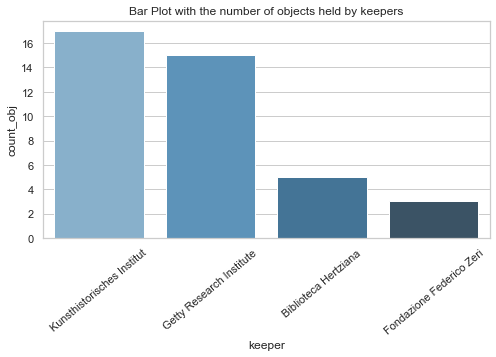

In [184]:
plt.figure(figsize = (8,4))
plt.xticks(rotation=40)
sns.barplot(x="keeper", y="count_obj", data=tot_per_keep, palette="Blues_d")
plt.title("Bar Plot with the number of objects held by keepers")

    3. How many collections with same objects for keeper
    
        3.1 ANALYSIS: Create a pivot with the previously computed data

In [196]:
object_pivot = obj_per_keep.pivot(index = 'object_type', columns = 'keeper', 
                      values = 'count_coll').fillna(0)
object_pivot

(insert to make a json file out of the obj_per_keep file to make the final graphics)

In [330]:
import json

json_treemap={'name':'All keepers', "children":[]}
n=0
while n<4:
    c=0
    dict1={}
    for i in range(len(obj_per_keep)):
        if obj_per_keep.loc[i, "keeper"]==obj_per_keep['keeper'].unique()[n]:
            #altra if clause in cui inserisci per la prima volta la chiave
            if c==0:
                #aggiungi chiave
                dict1={'name': obj_per_keep['keeper'].unique()[n], "children":[]}
            dict1['children'].append({'name':obj_per_keep.loc[i, "object_type"], 
                                      'size':int(obj_per_keep.loc[i, "count_coll"])})
            c+=1
    json_treemap['children'].append(dict1)
    n+=1

#print(json_treemap)

In [608]:
#with open('file_for_heat.json', 'w') as data_file:
#    json.dump(json_treemap, data_file, indent=2)

        3.2 GRAPHIC: HEATMAP

Text(0.5, 1.0, 'Heatmap with the number of objects held by keepers')

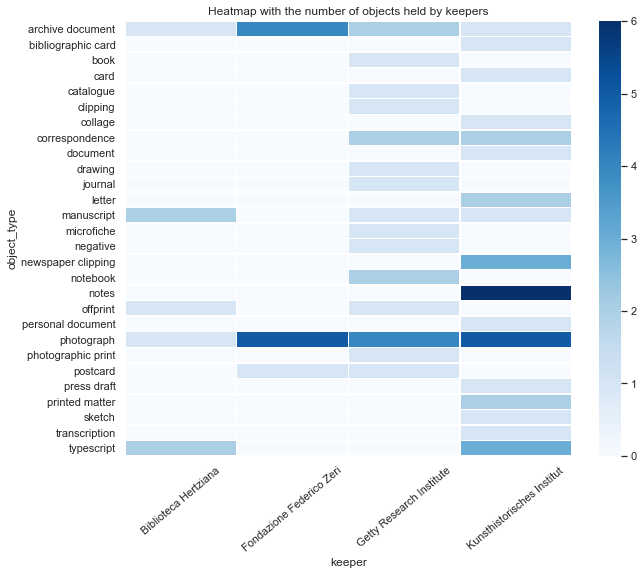

In [331]:
plt.figure(figsize = (10,8))
plt.xticks(rotation=40)
sns.heatmap(object_pivot, linewidths=.5, cmap="Blues")
plt.title("Heatmap with the number of objects held by keepers")

### END OF THE DATA ANALYSIS ON RENAISSANCE AND ON THE ART HISTORIANS 

### Small section dedicated to creating or modifying the files to use for final graphics

In [4]:
import csv
import json
import pandas as pd
import pandas_profiling as pp

#### Create a json for columnchart: QUESTION 1

In [5]:
df= pd.read_csv('Json_to_Sara/file_to_json.csv', sep=',', header=0)

1. Group by year and historian

In [6]:
all_grouped=df.groupby(['year', 'historian']).size().reset_index(drop=False)
all_grouped.columns = ["year", 'historian', "count_coll"]

2. Create a new df with historians and computed decades

In [7]:
data = {'historian': all_grouped['historian'],
        'decade':(10 * (all_grouped['year'] // 10)).astype(str) + 's'} 
decade_df=pd.DataFrame(data)
decade_df['historian']=decade_df['historian'].str.replace('Kornél Fabriczy', 'Cornelius von Fabriczy')
decade_df=decade_df.drop_duplicates().reset_index(drop=True)
decade_df.head(3)

,historian,decade
0,Gustav Ludwig,1880s
1,Cornelius von Fabriczy,1880s
2,Cornelius von Fabriczy,1890s


3. Create a basic dictionary to fill with historians names

In [8]:
dict_list=[
    {'decade':'1880s', 'historians':[], 'avg historians':1.0},
    {'decade':'1890s', 'historians':[], 'avg historians':1.4},
    {'decade':'1900s', 'historians':[], 'avg historians':2.5},
    {'decade':'1910s', 'historians':[], 'avg historians':2.0},
    {'decade':'1920s', 'historians':[], 'avg historians':2.9},
    {'decade':'1930s', 'historians':[], 'avg historians':5.4},
    {'decade':'1940s', 'historians':[], 'avg historians':7.6},
    {'decade':'1950s', 'historians':[], 'avg historians':9.7},
    {'decade':'1960s', 'historians':[], 'avg historians':9.6},
    {'decade':'1970s', 'historians':[], 'avg historians':9.4},
    {'decade':'1980s', 'historians':[], 'avg historians':9.1},
    {'decade':'1990s', 'historians':[], 'avg historians':7.6},
    {'decade':'2000s', 'historians':[], 'avg historians':4.5},
    {'decade':'2010s', 'historians':[], 'avg historians':2.8},
    {'decade':'2020s', 'historians':[], 'avg historians':1.0}
]

4. Add historians names in the dictionary

In [11]:
for ind in decade_df.index:
    cur_decade=decade_df['decade'][ind]
    for dictionary in dict_list:
        if dictionary['decade']==cur_decade:
            dictionary['historians'].append(decade_df['historian'][ind])
#conta quanti autori ci sono alla fine
#trasforma la lista di dizionari in un file json
dict_list

5. create the final json

In [53]:
#with open('Json_to_Sara/file_for_columnchart.json', 'w') as data_file:
#    json.dump(dict_list, data_file, indent=2)

#### Add the zeros to missing rows in csv for heatmap: QUESTION 2

In [12]:
#create the csv with all the zeros required to produce a heatmap
df= pd.read_csv('Json_to_Sara/heatmap2.csv', sep=',', header=0)
all_periods=df['Artistic Period'].unique()
all_decades=df['Timespan'].unique()
df.head(3)#.loc[df['Artistic Period'].str.contains('14th')]

,Artistic Period,Timespan,avg
0,14th century,1950,1.0
1,14th century,1960,1.0
2,14th century,1970,1.2


1. Find missing timespan for each artistic period and add a row for those values with avg 0

In [13]:
for period in all_periods:
    for decade in all_decades:
        if len(df.loc[(df['Artistic Period']==period) & (df['Timespan']==decade)])==0:
            row_to_add=pd.DataFrame({'Artistic Period':[period], 'Timespan':[decade], 'avg':[0.0]})
            df=df.append(row_to_add, ignore_index=True)
df['avg']=df['avg'].round(3)
df.loc[df['avg']==1.833]

,Artistic Period,Timespan,avg
51,Baroque,1920,1.833
86,Mannerism,1920,1.833


2. Sort values of the new df and create a new CSV file

In [14]:
df=df.sort_values(['Artistic Period', 'Timespan'], ascending=[True, True])
#df.to_csv('Json_to_Sara/heatmap2_correct.csv', index=False)
df.head(3)

,Artistic Period,Timespan,avg
176,14th century,1880,0.0
175,14th century,1890,0.0
170,14th century,1900,0.0
